## Uncertainty Estimation

We have seen that it was possible to obtain reasonably good estimates of the parameters, even with noisy fields values. However, it is crucial for practical application to also have an estimation uncertainty. 

In order to obtain uncertainty estimation values, we need to introduce a Bayesian framework. This means introducing some priors over the parameters. This should not be an issue since we normally would have nominal values for the components, or at least reasonable guesses or intervals for the values. 

Next we need to decide how to frame the optimization in the Bayesian framework. Here are some options: 

1. MAP estimate & Laplace estimate around the posterior mode: with this approach the prior influences the optimization with via a penalty term on the loss. Gradient based optimization (Adam) can then be employed to find the optimum, which in this case would be the MAP estimate. Finally, we assume the posterior is a Gaussian and we calculate the best fit using the Laplace approximation, which relies on computing the Hessian.

2. VI approach: should still be possible to use automatic-diff + Adam. 

3. HMC / NUTS: Since we only have 10 dimensions, there is no curse of dimensionality. Should be possible to draw **exact values from the posterior** without relying on surrogate models.  

4. Expectation Propagation (EP) Approaches: good with time-series. To be investigated. 

## Prior Distribution Family over the Physical Parameters

In [1]:
from pathlib import Path
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import h5py
import numpy as np


# change the working directory to the root of the project
sys.path.append(str(Path.cwd().parent))


from pinn_buck.config import Parameters
from pinn_buck.config import TRUE as TRUE_PARAMS, INITIAL_GUESS as INITIAL_GUESS_PARAMS
from pinn_buck.config import _SCALE

# load measurement interface
from pinn_buck.io import Measurement
from pinn_buck.noise import add_noise_to_Measurement

from pinn_buck.parameter_transformation import make_log_param, reverse_log_param
from pinn_buck.model.model_param_estimator import BuckParamEstimator
from pinn_buck.model.losses import l2_loss
from pinn_buck.io_model import TrainingRun

from pinn_buck.io import LoaderH5

### Parameter Nominal Values 

Now we need to define some nominal values for the parameters together with some realistic uncertainty estimates to simulate real engineering tasks. 

| Parameter | Description           | Nominal (N) | Tolerance / σ | Justification                      |
| --------- | --------------------- | ----------- | ------------- | ---------------------------------- |
| L         | Inductance            | 680 µH      | ±20%          | ±20% common for inductors          |
| RL        | Inductor resistance   | 0.3 Ω       | ±0.1 Ω        | DCR variation or estimation        |
| C         | Output capacitance    | 150 µF      | ±20%          | Electrolytics have wide tolerances |
| RC        | ESR of output cap     | 0.25 Ω      | ±40%          | Datasheet often gives a max        |
| Rdson     | Switch on-resistance  | 0.2 Ω       | ±10%          | MOSFETs vary with temperature      |
| Rload1    | Load resistor 1       | 3.3 Ω       | ±5%           | Depends on load spec               |
| Rload2    | Load resistor 2       | 10 Ω        | ±5%           | As above                           |
| Rload3    | Load resistor 3       | 6.8 Ω       | ±5%           | As above                           |
| Vin       | Input voltage         | 48 V        | ±2%           | From a regulated supply            |
| VF        | Diode forward voltage | 0.9 V       | ±0.1 V        | Varies with current/temperature    |


---

### Prior distribution family:
 we have to consider **Additive vs. Multiplicative Variation**.

* **Additive variation** means the component deviates by **adding or subtracting** some noise:

  $$
  x = x_0 + \epsilon
  \quad\text{(e.g., } \epsilon \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  This is typical of **normal (Gaussian)** noise.

* **Multiplicative variation** means the component value varies by being **scaled** up or down:

  $$
  x = x_0 \cdot (1 + \delta)
  \quad\text{(e.g., } \delta \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  Or more generally:

  $$
  \log x \sim \mathcal{N}(\mu, \sigma^2)
  \Rightarrow x \sim \text{LogNormal}(\mu, \sigma^2)
  $$

  This results in a **log-normal distribution** in linear space.

Considering how the components are manufactured:

* Component tolerances are often specified **as a percentage** (e.g., ±5%, ±10%).
* This means that the error **scales** with the magnitude.
* Example:

  * A 1 kΩ resistor with 5% tolerance → 950–1050 Ω
  * A 10 kΩ resistor with 5% tolerance → 9500–10500 Ω
    So the **absolute error grows** with the nominal value.

---

### Implication for Priors

If component values are specified with **percentage tolerances**, then we should model the distributions as:

$$
\log(x) \sim \mathcal{N}(\log(x_0), \sigma^2)
\quad\Rightarrow\quad
x \sim \text{LogNormal}
$$

This ensures:

* **Positivity**
* **Correct scaling of uncertainty**
* **Realistic tails** (e.g., 3σ errors reflect real-world max/min limits)


A log-normal distribution is suitable because:

* All parameters are positive
* Datasheet tolerances are multiplicative (e.g. ±20%)

For each parameter θ:

$$
p(\theta) = \frac{1}{\theta \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log \theta - \mu)^2}{2\sigma^2} \right)
$$

Where:

* μ = log(nominal value)
* σ = log(1 + relative tolerance)

## Notes
it may be more realistic to set a normal or truncated normal for some parameters, e.g. V_in, R_loads, but for now let's assume a lognormal for all components. 

However, setting all priors to be a log-normal is a good initial choice, since: 

1. Log-normal distributions naturally enforce positivity, which is a desirable property for **every parameter** in your model.

2. If the **relative standard deviation** is small (say < 10%), then a log-normal is **almost symmetric** and looks very much like a normal.

3. Modeling simplicity of using a log-normal for all parameters means:
    * One consistent implementation for priors
    * All prior PDFs live in log-space → simple KL terms in VI
    * Posterior approximations (Laplace, variational) share the same structure

    This pays off during training, debugging, and when visualizing uncertainty.

---

### ⚠️ Risks of using Log-Normal 

The core issue here is **how the prior interacts with the likelihood** to shape the posterior when the prior is **skewed** (like a log-normal) and the likelihood is **tight** (very confident).
 
#### log-normal priors can become problematic in narrow posterior regimes

Log-normal distributions are **asymmetric**:

* The **mode** is less than the **mean**
* The density decays **faster** on the left (toward 0) than on the right

Now suppose the **likelihood (data)** is very confident about, say, $V_{in} = 48.1 \, \text{V}$, with very little uncertainty:

  1. The prior is **skewed right**:

      * Most mass is slightly above 48 V

      * The mode is < 48 V (since log-normal mode = exp(μ − σ²))

  2. The posterior, which is proportional to:

  $$
  \text{posterior} \propto \text{likelihood} \times \text{prior}
  $$

  gets **pulled** by this skewed prior.



> If the data is highly informative and points to a value slightly **above** the nominal (e.g. 48.1 V), the **log-normal prior puts less mass there** than a normal would. 
    * The posterior mean gets **pulled lower**
    * The posterior becomes **skewed left**
    * The Laplace approximation (Gaussian) might **not match** the real shape

So if your posterior is very concentrated and the prior is skewed, **even a small mismatch** between the likelihood peak and the prior mode can:

* Shift the posterior
* Lead to incorrect uncertainty quantification
* Mislead downstream predictions if you're sampling
    Result:


---

## ✅ Why a normal prior helps in this case

A **normal prior** is symmetric. So:

* It doesn't bias the posterior toward lower or higher values
* The posterior stays centered where the data wants it to be
* The Laplace (or mean-field VI) approximation is more accurate

In summary, consider changing to a normal only if:

* The posteriors for $V_{in}$ or $R_{\text{load}}$ are **very tightly concentrated**, and
* Your Laplace or VI posterior is **asymmetric or biased** due to the log-normal prior's skew


In [2]:
import matplotlib
from scipy.stats import lognorm
from pinn_buck.config import Parameters


# Nominals and linear-space relative tolerances
NOMINAL = Parameters(
    L=6.8e-4,
    RL=0.4,
    C=1.5e-4,
    RC=0.25,
    Rdson=0.25,
    Rload1=3.3,
    Rload2=10.0,
    Rload3=6.8,
    Vin=46.0,
    VF=1.1,
)

REL_TOL = Parameters(
    L=0.50,
    RL=0.4,
    C=0.50,
    RC=0.50,
    Rdson=0.5,
    Rload1=0.3,
    Rload2=0.3,
    Rload3=0.3,
    Vin=0.3,
    VF=0.3,
)


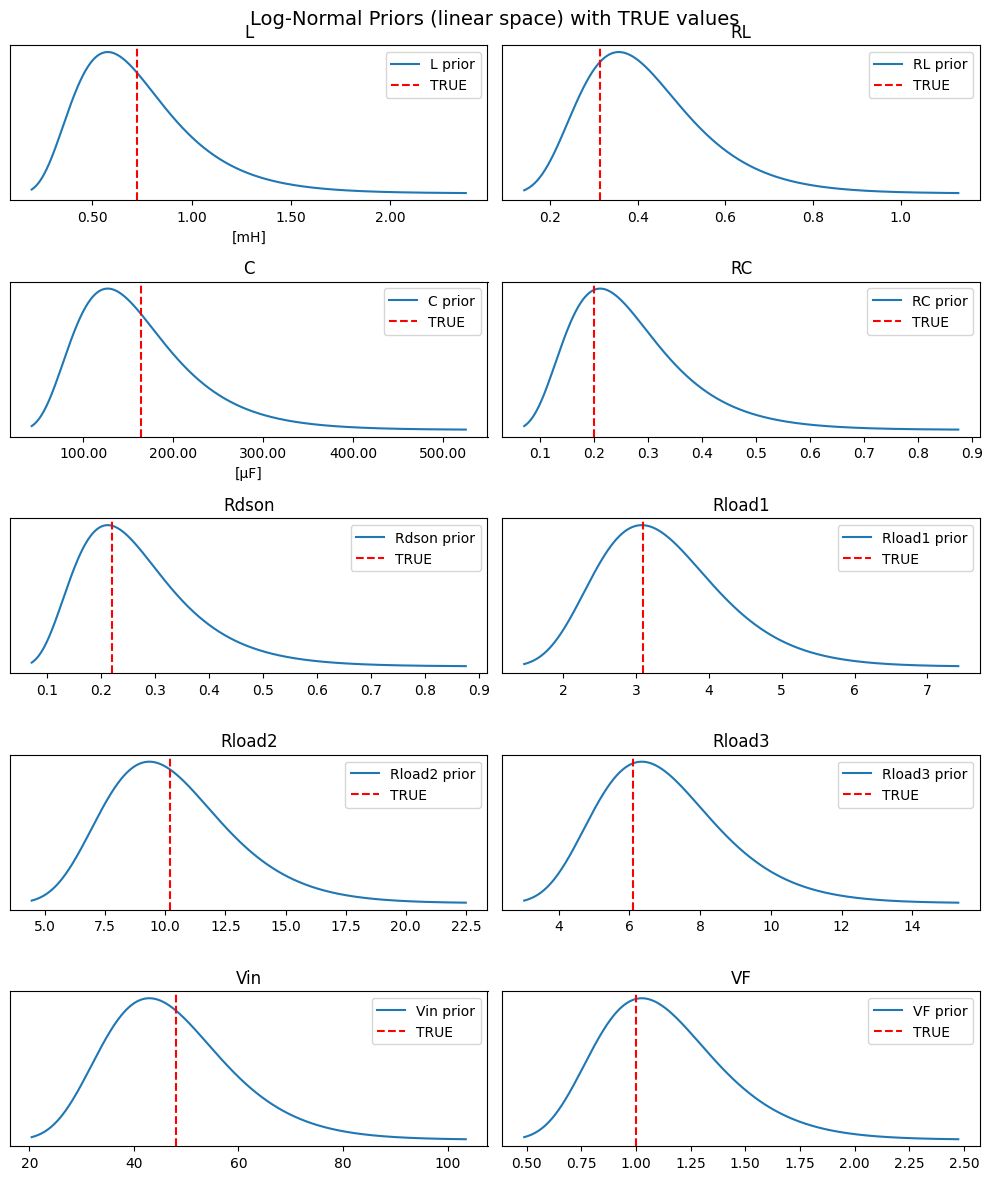

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()

for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()
    
    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Benchmark

Let's inspect a normal run of the Adam optimizer with the nominal values as initial guess

In [4]:
import torch
import torch.nn as nn


def set_seed(seed: int = 1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)
device = "cpu"


## MAP Estimation

In order to get a MAP estimation, we have to consider the priors and try to maximize the posterior distribution on the parameters following Bayes' rule: 
$$ p(z | x = D) = p(x=D | z) \cdot p(z) / p(x=D) $$
However, even in this low dimensional case with 10 latent parameters $z$, which are the physical parameters of the circuit, it is difficult to numerically compute the marginal $$p(x=D) = \int_z p(x=D | z) p(z) dz$$

However, we know that the marginal does not depend on the particular choice of z, so the level set for fixed x=D of the joint $p(x=D, z) = p(x=D | z) \cdot p(z)$ is proportional to the posterior: 
$$ p(z | x = D) \propto  p(x=D, z)$$
Then it is possible to get the MAP solely by analyzing the joint distribution since: 
$$ \argmax_z p(z | x=D) = \argmax_z p(x=D, z)$$

In this application we have a supervised model, so
$$y = f(x, z)$$
And he dataset is $\mathcal D=\{(x_i,\,y_i)\}_{i=0}^{N-1}$.

We can rewrite: 
$$ p(z | x, y = D) \propto  p(y=D_y, z | x=D_x) =  p(y = D_y \mid x, z) p(z)$$

### Definition of the loss function
Now we can elaborate on the expression of the MAP estimate, that searches for $z_{\text{MAP}}=\argmax_z p(y=D, z | x)$. To this end, we chose the Negative Log Likelihood as a loss function

\begin{align}
    \text{NLL}(z) &= - \log p(y=D, z | x) \\
    &= -\log p(y=D | z, x) - \log p(z)
\end{align}

With the hypothesis of independent draws of the observed variables x that form the dataset: 
$$ p(y=D | z, x) = \prod_{i=0}^{N-1} p(y_i | x_i, z) $$


## Consider the choice of Distribution

### Prior
We have chosen a Log-Normal distribution to represent the pdf over the circuit parameters: 
$$p(x) = \frac{1}{x \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log x - \mu)^2}{2\sigma^2} \right)$$

or equivalently $\log x \sim \mathcal{N}(x; \mu, \sigma)$:

$$p(\log x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\log x - \mu)^2}{2\sigma^2}\right)$$

Then: 
\begin{align}
    \log p(\log z) &= \log \left[\frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(-\frac{(\log z - \mu_0)^2}{2\sigma_0^2}\right)\right]\\
                & \propto -\frac{(\log z - \mu_0)^2}{2\sigma_0^2}
\end{align}

Assuming the priors are independently drawn: 
$$
\log p(\log z)= -\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}+\text{const}.
$$



### Likelihood
Assuming the **observations** $\{x_i\}_{i=0}^{N-1}$ are  corrupted by additive homoscedastic Gaussian sensor noise, so the observation random variables are **independent and Gaussian distributed** with a likelihood of the form $y_i \mid x_i,z \;\sim\; \mathcal N\!\bigl(f(x_i,z),\,\sigma_x^{2}\mathbf I\bigr)$, the total log-likelihood is:

$$
\log p(\mathbf y\mid\mathbf x,z)
  = -\frac{1}{2\sigma_x^{2}}\sum_{i=0}^{N-1}\!
      \bigl\|\,y_i-f(x_i,z)\bigr\|^{2} + \text{const}.
$$
Note that $\sigma_x$ is the noise in the observed dataset. However, it can be useful to instead consider the distribution of residuals $r_n = y - f(x,z)$, which, if for now we consider $f(x,z)$ deterministic, is $r_n \sim \mathcal{N}(0, \sigma_x^{2}\mathbf I)$, i.e. **it also exhibits an uncertainty derived from the data noise $\sigma_x$**.  

### NLL - MAP objective
So the nnegative log likelihood becomes: 
$$ \text{NLL}(z)=
\frac{1}{2\sigma_x^{2}}
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(\log z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}
+ \text{const}.
$$

Note that we assume a fixed variance of the observation that doesn't depend on the values of the input parameters, i.e. we assume **homoschedasticity**. Note that this makes sense: 
    
>  "The parameters determine the mean values of the observed data with some random noise whose variance depends on random factors, independent on the data."

Many times, the prior assumptions are weak and therefore, therefore $\sigma_0$ is allowed to control the data-prior balance entirely. However, in our case we are considering different solutions with different noise powers. Therefore, we should consider both $\sigma_x$ and $\sigma_0$ explicitly. We can rewrite the NLL as: 

$$\text{NLL}(z) = \frac{1}{2\sigma_x^2} \left[
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+ \frac{\sigma_x^2}{\sigma_0^2} \sum_{k=1}^{10}
      \bigl(\log z_k-\mu_{0,k}\bigr)^{2}
\right] + \text{const.}$$

Since $\frac{1}{2\sigma_x^2}$ only changes the scale of the NLL we can ignore this term to obtain:

$$\text{NLL}(z) = \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+ \underbrace{\frac{\sigma_x^2}{\sigma_0^2}}_\lambda \sum_{k=1}^{10}
      \bigl(\log z_k-\mu_{0,k}\bigr)^{2} + \text{const.}$$

Here we can set $\frac{\sigma_x^2}{\sigma_0^2}=\lambda$ and we can see that we obtain a new parameter that regulates how much weights we want to give to the prior. Indeed, if the data is noisy, then $\lambda \uparrow$ and the prior has a stronger influence on the loss, while if the data noise is very low, $\lambda \downarrow$ and we quickly move away from our prior convictions. 

It is common in these setups to directly tune $\lambda$ as a hyperparameter, for example via cross-validation and grid search. However, in our case there is a strong physical interpretation for these quantities and we may have a meaningful insite on the prior range on the parameters from datasheets or manufactorers. Moreover, we may also have some knowledge on the noise present in our measurements. Therefore, we can maintain the original expression for the posterior loss:

$$\text{NLL}(z)=
\frac{1}{2\sigma_x^{2}}
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(\log z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}
+ \text{const}.$$


## Noisy Observations

In the previously described model, all observation noise was attributed to the target variable:

$$
y \sim \mathcal{N}(f(x, z), \sigma_x^2).
$$

However, in our specific setup, the target $y = x_{n+1}$ is itself an observed state, and so is the input $x = x_n$. Both are corrupted by measurement noise of the same variance:

$$
x_n^{\text{obs}} = \tilde{x}_n + \eta_n, \quad \eta_n \sim \mathcal{N}(0, \sigma_x^2),
$$

$$
y_n^{\text{obs}} = x_{n+1}^{\text{obs}}.
$$

We use a deterministic model $f(z, x_n)$, typically an RK4 integrator, to predict the next state. The residuals between the noisy target and the prediction are:

$$
r_n(z) = y_n^{\text{obs}} - f(z, x_n^{\text{obs}}).
$$

If noise levels were unknown, we could estimate the total predictive variance directly from the residuals:

$$
\hat{\sigma}_{\text{tot}}^2 = \frac{1}{N} \sum_{n=1}^N \left( r_n^{\text{nom}} - \bar{r}^{\text{nom}} \right)^2,
$$

where the residuals are computed using the nominal parameters $z_{\text{nom}}$. This is effectively empirical risk minimization and yields an approximate observation noise model, albeit biased by imperfect parameters.

---

### Analytical Estimation (When Noise is Known)
We have a noisy observation $x^{\text{obs}}\!\sim\!\mathcal N(x,\sigma_x^2)$ and the forward model is a scalar
$y^{\text{obs}}=f(x^{\text{obs}})$.

Let us consider the residual we want to minimize: 
$r_n^{\text{obs}} = x_{n}^{\text{pred}}-x_{n}^{\text{obs}}$

Then we see that: 
$$x_{n}^{\text{pred}} = f(x_{n-1}^{\text{obs}})$$


We can approximate the function with the first order Taylor expansion:
\begin{align}
f(x_{n-1}^{\text{obs}}) &= f(x_{n-1} + \varepsilon_{n-1}) \\
&\simeq f(x_{n-1}) + \frac{\partial f}{\partial x} \varepsilon_{n-1}
\end{align}

Where $\frac{\partial f}{\partial x}$ is the Jacobian $J$
Putting everything together we get: 
\begin{align}
r_n^{\text{obs}} &= f(x_{n-1}) - x_n + J \varepsilon_{n-1} - \varepsilon_{n}\\
&= r_{n} + \epsilon_{r}
\end{align}

So $r_n \sim \mathcal{N}(r_{n}, \Sigma_r)$.

We can calculate the variance by looking at the random variable $\varepsilon_{r} = J \varepsilon_{n-1} - \varepsilon_{n}$. Since we assume the noise on the data is white gaussian noise, so $\varepsilon_{n-1}$ and \varepsilon_{n-1}$ are independent, we get: 

$$\operatorname{Var}[r_n^{\text{obs}}] = ||J||^2 \Sigma_x + \Sigma_x = (1+||J||_F^2) \Sigma_x$$

In conclusion: 
$$
\boxed{
   r_n^{\text{obs}} \sim \mathcal{N}(r_{n}, (1+||J||_F^2)\Sigma_x)
}
$$

This decomposition highlights that uncertainty propagates from $x_n$ through the model via its Jacobian with respect to $x$. Thus, even if the model is deterministic, input uncertainty affects the output distribution.

#### Interpretation and Estimation of the Jacobian

Importantly, the Jacobian, i.e. the derivative $\partial f / \partial x$, is **not** a time derivative like $(x_{n+1} - x_n) / dt$. It is a sensitivity derivative that answers the question:

> *"How much would the prediction $f(z, x_n)$ change if I slightly perturbed the input $x_n$?"*

This derivative captures how uncertainty in the current state propagates into uncertainty in the next predicted state.

We then need to numerically estimate the Jacobian norm:

$$
\left\langle \|J(z_\text{nom})\|_F^2 \right\rangle_n,
$$

This can be done by looping through the training inputs $x_n$, computing the Jacobian with respect to the model input $x_n$ via autograd, and aggregating the squared norm of these matrices. Obviously, the derivatives depends also on the latent parameters $z$, which are unknown before training. However, we can use the nominal values to provide a good guess. 

This yields a scalar correction factor that adjusts the data loss scale in the MAP objective.

## Independent v and i noises

In practice the noise levels on v and i can be quite different. Moreover, the estimation of the voltage in the next location will depend on both previous voltage and current as well as the current in the next step will depend on both previous voltage and current. However, the sensitivity to one may be different from the sensitivity to the other. Therefore we have to consider the full 2x2 Jacobian.


#### 2 .  Vector case with diagonal noise

Let the measured state be

$$
x_n^{\text{obs}}=(i_n^{\text{obs}},\,v_n^{\text{obs}})^\top,
\qquad
y_n^{\text{obs}}=(i_{n+1}^{\text{obs}},\,v_{n+1}^{\text{obs}})^\top .
$$

Assume **independent** noises

$$
\Sigma_x=\mathrm{diag}\!\bigl(\sigma_i^{2},\;\sigma_v^{2}\bigr),\qquad
\Sigma_y=\mathrm{diag}\!\bigl(\sigma_i^{2},\;\sigma_v^{2}\bigr),
$$

and let

$$
J=\frac{\partial f}{\partial x}
=\begin{bmatrix}
J_{11}&J_{12}\\[2pt]
J_{21}&J_{22}
\end{bmatrix}\in\mathbb R^{2\times2}.
$$

The residual covariance is

$$
\boxed{
\Sigma_{\text{tot}}
   =\Sigma_x + J\,\Sigma_x\,J^\top
}
$$


## Forward and Backward Predictions

In the previous derivation we are considering only the forward prediction, which simplifies the mathematics of the model. However, the model can incorporate both forward and backward predictions. Let's investigate whether the backward prediction is necessary by optimizing the parameters using only the likelihood loss: 

$$\sum_{i=0}^{N-1}\!\bigl\|r_n^{\text{fw}}\bigr\|^{2}$$

and compare with a term that considers both forward and backward terms: 

$$\sum_{i=0}^{N-1}\!\bigl\|r_n^{\text{fw}}\bigr\|^{2} + \bigl\|r_n^{\text{bw}}\bigr\|^{2}$$


Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


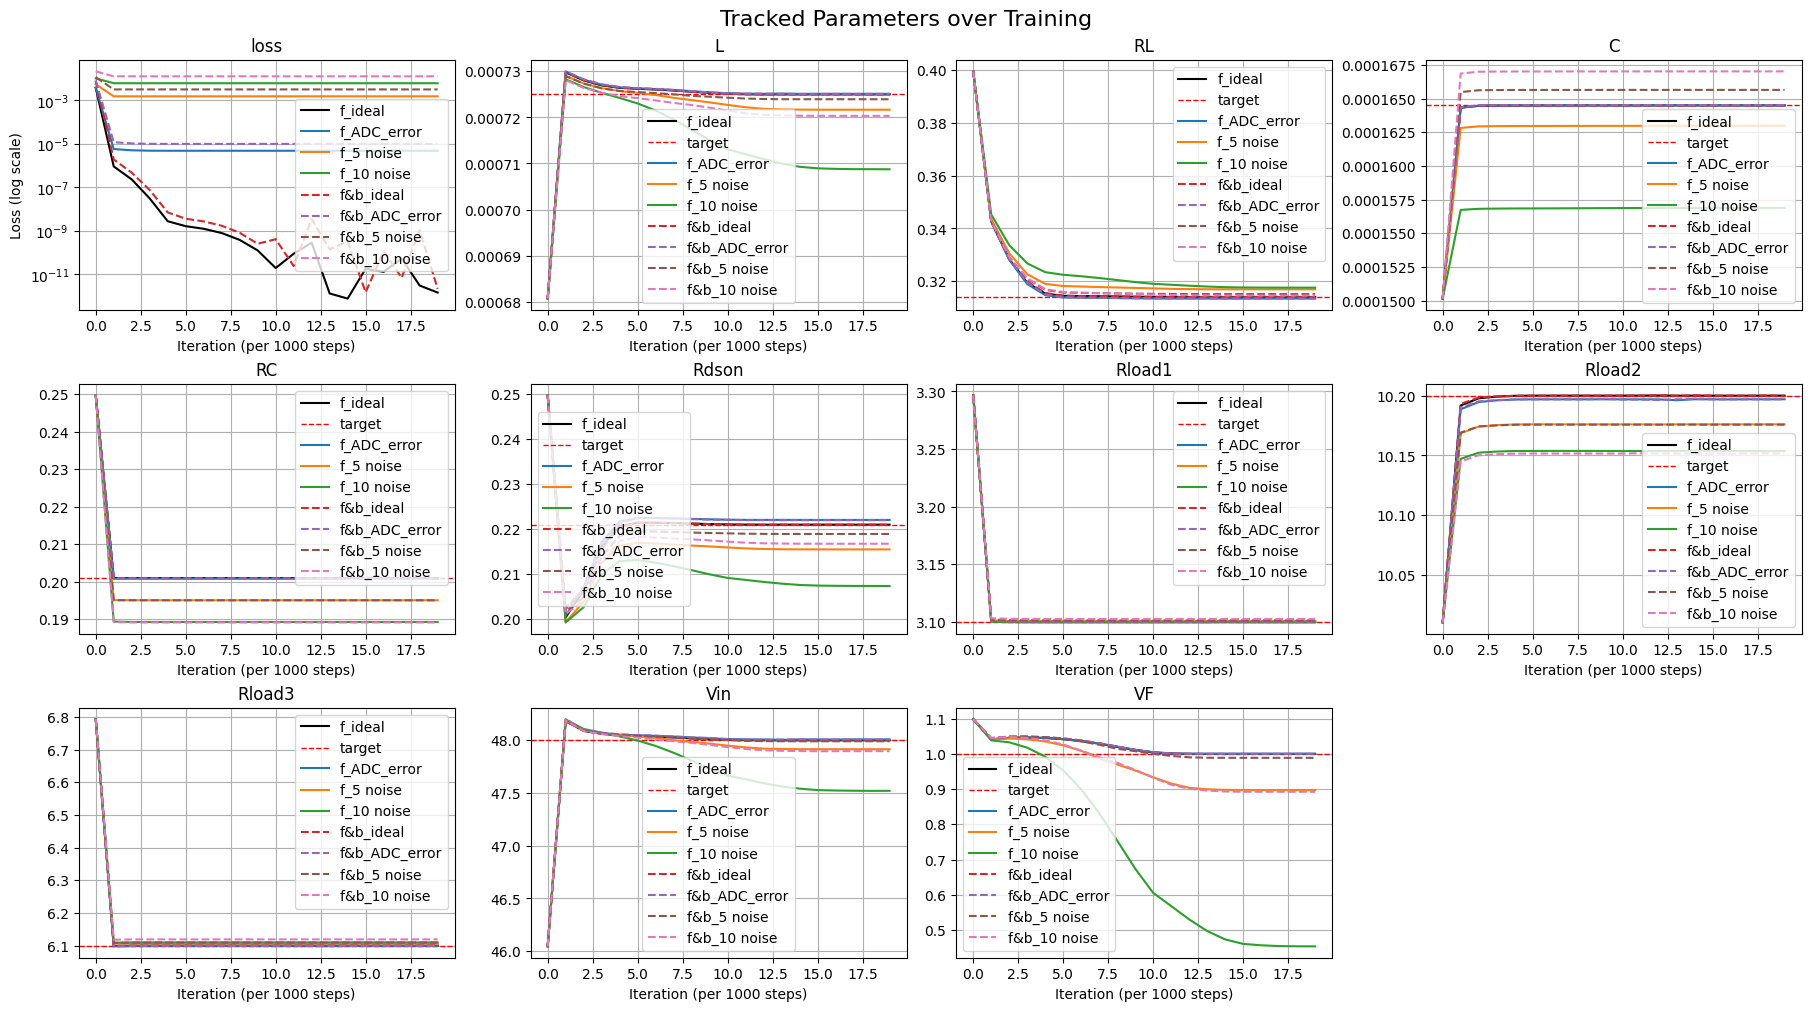

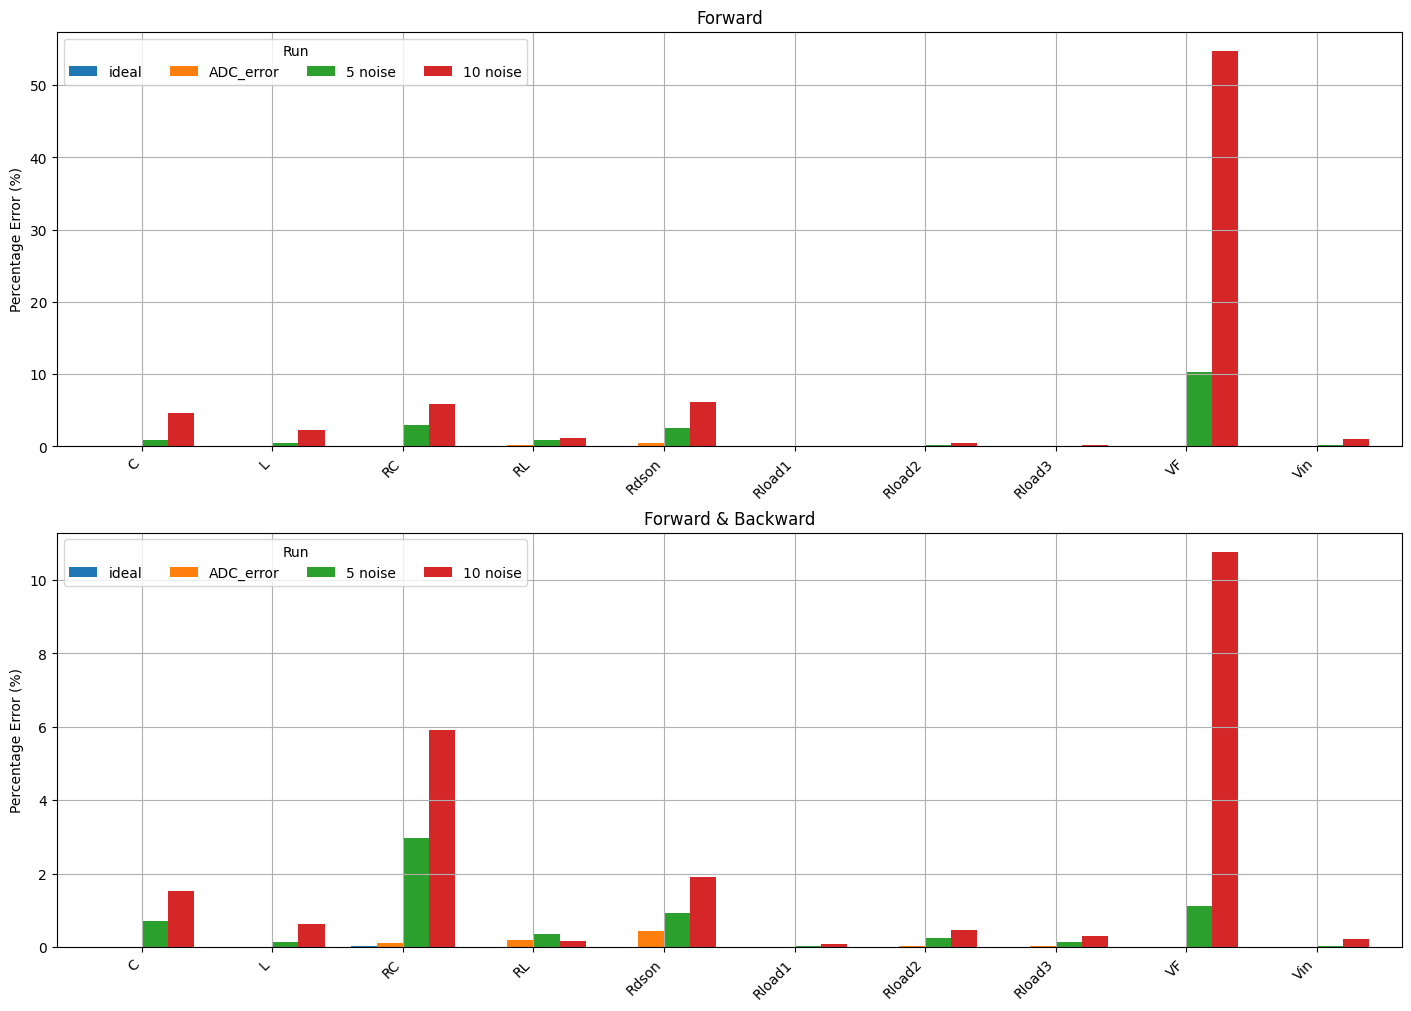

In [5]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
fb_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward&backward"
)
f_outdir = Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward"


csv_files = list(f_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "f_" + label
    if ii == 0:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_f = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


csv_files = list(fb_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "f&b_" + label
    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None, linestyle="--")

runs_ordered_fb = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


fig, ax = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_f, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[0]
)
plot_final_percentage_error_multi(
    runs=runs_ordered_fb, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[1]
)

ax[0].set_title("Forward")
ax[1].set_title("Forward & Backward");

It can be seen from the results of the two optimizations that it is **necessary to consider both forward and backward prediction terms** especially to increase robustness to noise in the data.

Let's introduce a statistical interpretation of this setup

### Likelihood with Forward and Backward Residuals

In our parameter estimation model, we simulate both forward and backward time integration using a Runge–Kutta (RK4) solver. At each internal time index $n$, we obtain two residuals:

* The **forward residual**, which compares the next observation to a forward prediction from $x_n$,
* The **backward residual**, which compares the current observation to a backward prediction from $x_{n+1}$:

$$
\begin{aligned}
r_n^{\text{fw}} &= y_{n+1} - f_\rightarrow(x_n, z), \\
r_n^{\text{bw}} &= y_n - f_\leftarrow(x_{n+1}, z),
\end{aligned}
$$

where $f_\rightarrow$ and $f_\leftarrow$ denote RK4 propagation in the forward and backward time directions, respectively. If we assume both residuals are corrupted by independent Gaussian noise with covariance $\sigma_x^2 \mathbf{I}$, then we can treat the two residuals as **independent**, each distributed as:

$$
r_n^{\text{fw}},\, r_n^{\text{bw}} \sim \mathcal{N}(0, \sigma_x^2 \mathbf{I}).
$$

Under this assumption, the log-likelihood over all $N$ internal time steps becomes:

$$
\log p(\mathbf{y} \mid \mathbf{x}, z)
= -\frac{1}{2\sigma_x^2} \sum_{n=0}^{N-1}
\left(
\|r_n^{\text{fw}}\|^2 + \|r_n^{\text{bw}}\|^2
\right) + \text{const}.
$$

This corresponds to the **loss function**:

$$
\mathcal{L}_{\text{fw+bw}}(z) = \sum_{n=0}^{N-1}
\left(
\|y_{n+1} - f_\rightarrow(x_n, z)\|^2
+ \|y_n - f_\leftarrow(x_{n+1}, z)\|^2
\right),
$$

and yields the MAP objective:

$$
\text{NLL}(z) =
\frac{1}{2\sigma_x^2} \mathcal{L}_{\text{fw+bw}}(z)
+ \frac{1}{2} \sum_{k=1}^{10}
\frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}
+ \text{const}.
$$

If desired, the ratio $\lambda = \sigma_x^2 / \sigma_0^2$ can be treated as a tunable regularization weight on the prior penalty.

> **This is exactly the loss function we have been using with some success!**

---

### Incorporating Residual Correlations

In reality, the residuals $r_n^{\text{fw}}$ and $r_n^{\text{bw}}$ are not independent. Both depend on the same noisy measurements $y_n$ and $y_{n+1}$, and their errors propagate through the respective RK4 solvers. 

Indeed, let us assume the model makes predictions through a (possibly nonlinear) function locally approximated by a **Jacobian** matrix $J_n$, i.e.,

$$
y_{n+1}^{\text{pred}} \approx J_n y_n^{\text{obs}}.
$$

Similarly, the **backward prediction** is modeled as:

$$
y_n^{\text{pred}} \approx J_n^{-1} y_{n+1}^{\text{obs}}.
$$

Assuming the observation noise $\varepsilon_n \sim \mathcal{N}(0, \Sigma_x)$, we have:

* $y_n^{\text{obs}} = y_n^{\text{true}} + \varepsilon_n$
* $y_{n+1}^{\text{obs}} = y_{n+1}^{\text{true}} + \varepsilon_{n+1}$
* with independent noise terms: $\operatorname{Cov}(\varepsilon_n, \varepsilon_{n+1}) = 0$

Then, using the linearized model, we write the residuals as:

$$
r_n^{\text{fw}} = J_n \varepsilon_n - \varepsilon_{n+1}
$$

$$
r_n^{\text{bw}} = J_n^{-1} \varepsilon_{n+1} - \varepsilon_n
$$

### Covariance Matrix Derivation

Now we compute the joint covariance:

$$
\Sigma_r(J_n) = \mathbb{E}[r_n r_n^\top]
$$

Write it block-wise:

$$
\Sigma_r(J_n) = \begin{pmatrix}
\mathbb{E}[r_n^{\text{fw}} (r_n^{\text{fw}})^\top] & \mathbb{E}[r_n^{\text{fw}} (r_n^{\text{bw}})^\top] \\
\mathbb{E}[r_n^{\text{bw}} (r_n^{\text{fw}})^\top] & \mathbb{E}[r_n^{\text{bw}} (r_n^{\text{bw}})^\top]
\end{pmatrix}
$$

Compute each block:

---

### Top-left: forward–forward

$$
\mathbb{E}[r_n^{\text{fw}} (r_n^{\text{fw}})^\top]
= \mathbb{E}[(J_n \varepsilon_n - \varepsilon_{n+1})(J_n \varepsilon_n - \varepsilon_{n+1})^\top]
= J_n \Sigma_x J_n^\top + \Sigma_x
$$

---

### Bottom-right: backward–backward

$$
\mathbb{E}[r_n^{\text{bw}} (r_n^{\text{bw}})^\top]
= \mathbb{E}[(J_n^{-1} \varepsilon_{n+1} - \varepsilon_n)(J_n^{-1} \varepsilon_{n+1} - \varepsilon_n)^\top]
= J_n^{-1} \Sigma_x J_n^{-\top} + \Sigma_x
$$

---

### Top-right: forward–backward

$$
\mathbb{E}[r_n^{\text{fw}} (r_n^{\text{bw}})^\top]
= \mathbb{E}[(J_n \varepsilon_n - \varepsilon_{n+1})(J_n^{-1} \varepsilon_{n+1} - \varepsilon_n)^\top]
$$

Expanding:

$$
= -J_n \mathbb{E}[\varepsilon_n \varepsilon_n^\top] - \mathbb{E}[\varepsilon_{n+1} \varepsilon_{n+1}^\top] J_n^{-\top}
= -J_n \Sigma_x - \Sigma_x J_n^{-\top}
$$

---

### Bottom-left: backward–forward

This is the transpose of the top-right block:

$$
\mathbb{E}[r_n^{\text{bw}} (r_n^{\text{fw}})^\top]
= -\Sigma_x J_n^\top - J_n^{-1} \Sigma_x
$$

---

### Final Covariance Matrix

$$
\Sigma_r(J_n) = \begin{pmatrix}
J_n \Sigma_x J_n^\top + \Sigma_x & -J_n \Sigma_x - \Sigma_x J_n^{-\top} \\
-\Sigma_x J_n^\top - J_n^{-1} \Sigma_x & J_n^{-1} \Sigma_x J_n^{-\top} + \Sigma_x
\end{pmatrix}
$$

---

## Sanity Check: $J_n \approx I$

If $J_n = I$, the Jacobian is the identity:

* $J_n \Sigma_x J_n^\top = \Sigma_x$
* $J_n^{-1} = I$
* $J_n^{-\top} = I$

Substitute into the expression:

$$
\Sigma_r(I) = \begin{pmatrix}
2\Sigma_x & -2\Sigma_x \\
-2\Sigma_x & 2\Sigma_x
\end{pmatrix}
$$

---

### Interpretation

* The **diagonal blocks** $2\Sigma_x$ reflect that each residual includes two independent noise contributions.
* The **off-diagonal blocks** $-2\Sigma_x$ indicate **perfect anti-correlation** between the forward and backward residuals when the model is identity: if one step is overestimated, the other is underestimated symmetrically.
* This makes sense because the backward step essentially inverts the forward step—any error in one direction propagates oppositely in the reverse direction.
* In probabilistic terms, this anti-correlation reduces the effective uncertainty when combining forward and backward information—a key feature that can be exploited in inference (e.g., smoother estimates, better likelihoods).


This covariance structure is crucial when computing a likelihood or Mahalanobis loss over stacked forward-backward residuals.

### Intuitive Example

Suppose the system is one-dimensional, so $\Sigma_x = \sigma^2$, and $J_n = 1$ (i.e., identity dynamics).

Let’s consider what happens when **observation noise perturbs $x_n^{\text{obs}}$ upward**:

* Assume the true state is $x_n = 1.0$, but due to noise, the observation is $x_n^{\text{obs}} = 1.1$ (i.e., a positive error).
* The forward model is $x_{n+1}^{\text{pred}} = J_n x_n^{\text{obs}} = 1.1$
* But let the true value be $x_{n+1} = 1.0$, and suppose the observed value $x_{n+1}^{\text{obs}} \approx 1.0$

Then:

* **Forward residual**:

  $$
  r_n^{\text{fw}} = x_{n+1}^{\text{pred}} - x_{n+1}^{\text{obs}} \approx 1.1 - 1.0 = +0.1
  $$

* **Backward prediction**:

  $$
  x_n^{\text{pred}} = J_n^{-1} x_{n+1}^{\text{obs}} = 1.0
  $$

* **Backward residual**:

  $$
  r_n^{\text{bw}} = x_n^{\text{pred}} - x_n^{\text{obs}} = 1.0 - 1.1 = -0.1
  $$

So we observe:

* $r_n^{\text{fw}} = +0.1$
* $r_n^{\text{bw}} = -0.1$

They are **perfectly anti-correlated**, which is exactly what the off-diagonal blocks $-2\Sigma_x$ represent in expectation.

## Putting all Together
The corresponding log-likelihood for each time step becomes:

$$
\log p(r_n \mid z) =
- \frac{1}{2} r_n^\top \Sigma_r(J_n)^{-1} r_n
- \frac{1}{2} \log \det \Sigma_r(J_n) + \text{const}.
$$

The second term is constant with respect to the residuals so we neglect it. 
Summing over all steps and adding the log-prior gives the complete MAP objective:

$$
\text{NLL}(z) =
\frac{1}{2}
\sum_{n=0}^{N-1}
r_n^\top \Sigma_r(J_n)^{-1} r_n
+ \frac{1}{2} \sum_{k=1}^{10}
\frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}
+ \text{const}.
$$

This is a **statistically efficient generalization** of the independent residual loss. 


### Our Application

In our case, each measurement $y_n = [i_n, v_n]^\top$ is a 2D vector containing the current and voltage of the converter. Consequently, the residuals $r_n^{\text{fw}}, r_n^{\text{bw}} \in \mathbb{R}^2$, and each Jacobian $J_n\in\mathbb{R}^{2\times 2}$. Therefore, the full residual vector $r_n \in \mathbb{R}^4$, and the block covariance matrix $\Sigma_r(J_n)\in\mathbb{R}^{4\times 4}$.

## Optimizing on the Full Sigma matrix

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


Text(0.5, 1.0, 'Forward & Backward')

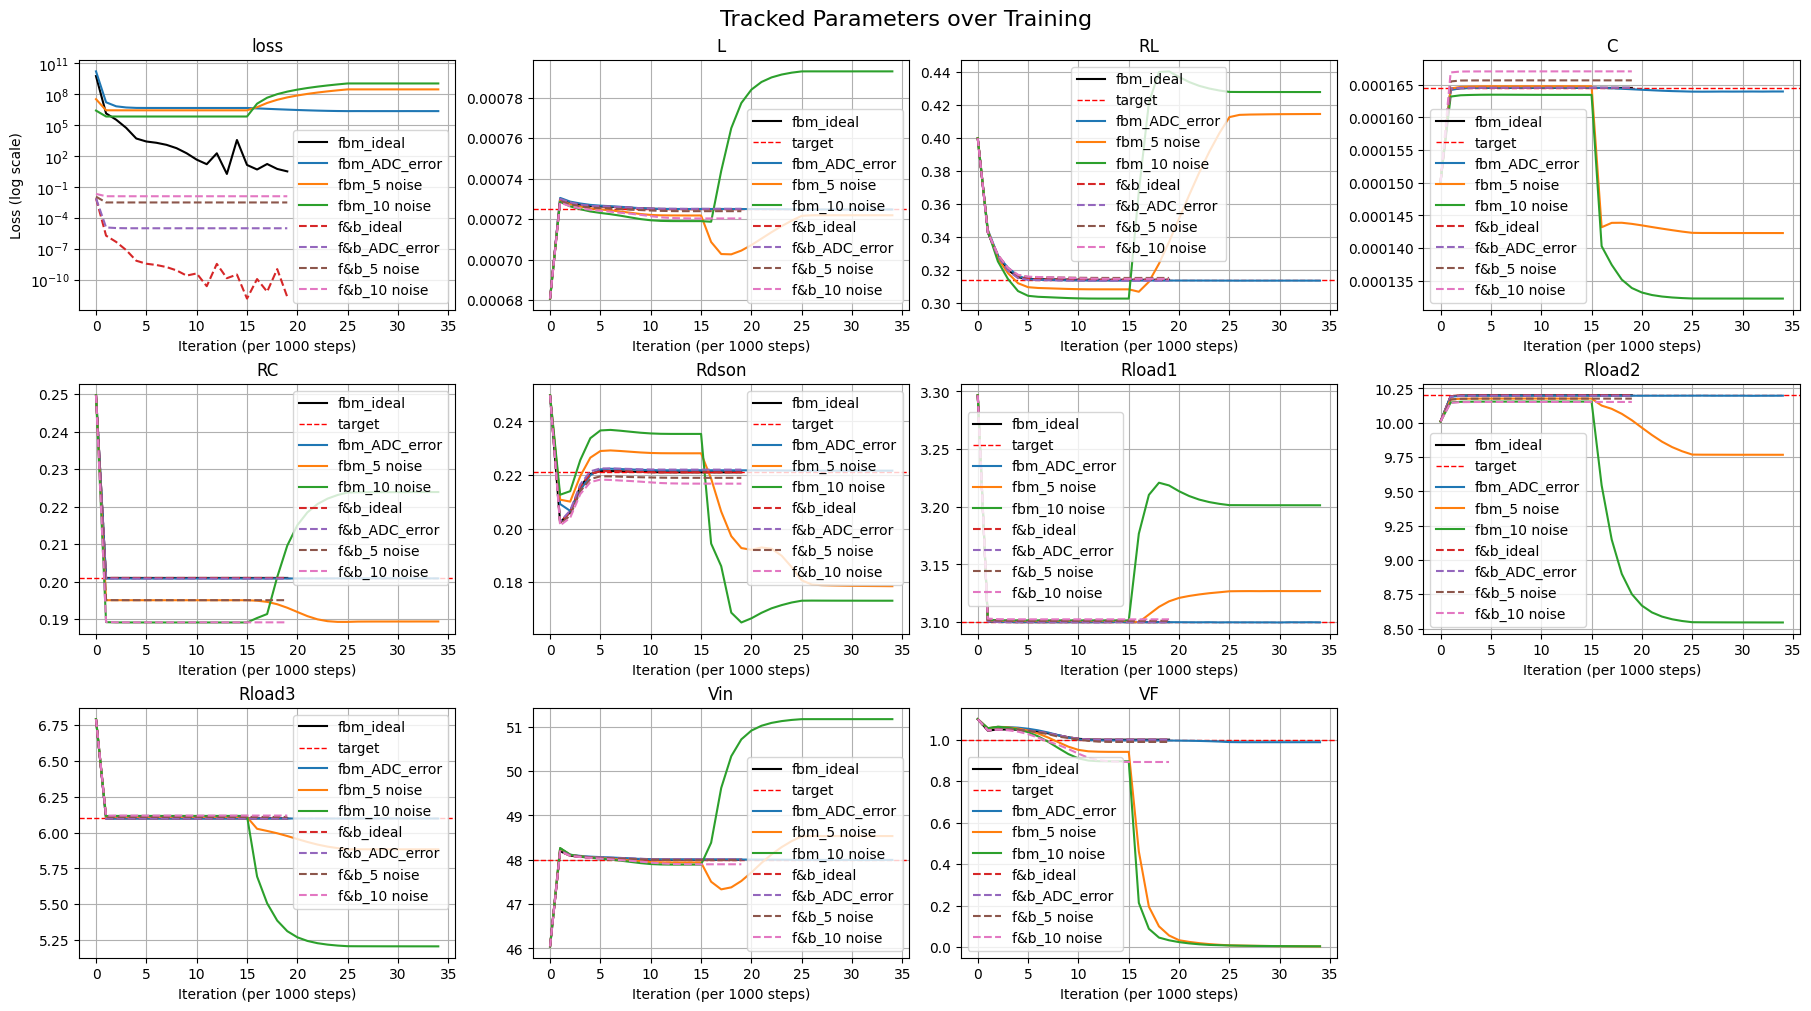

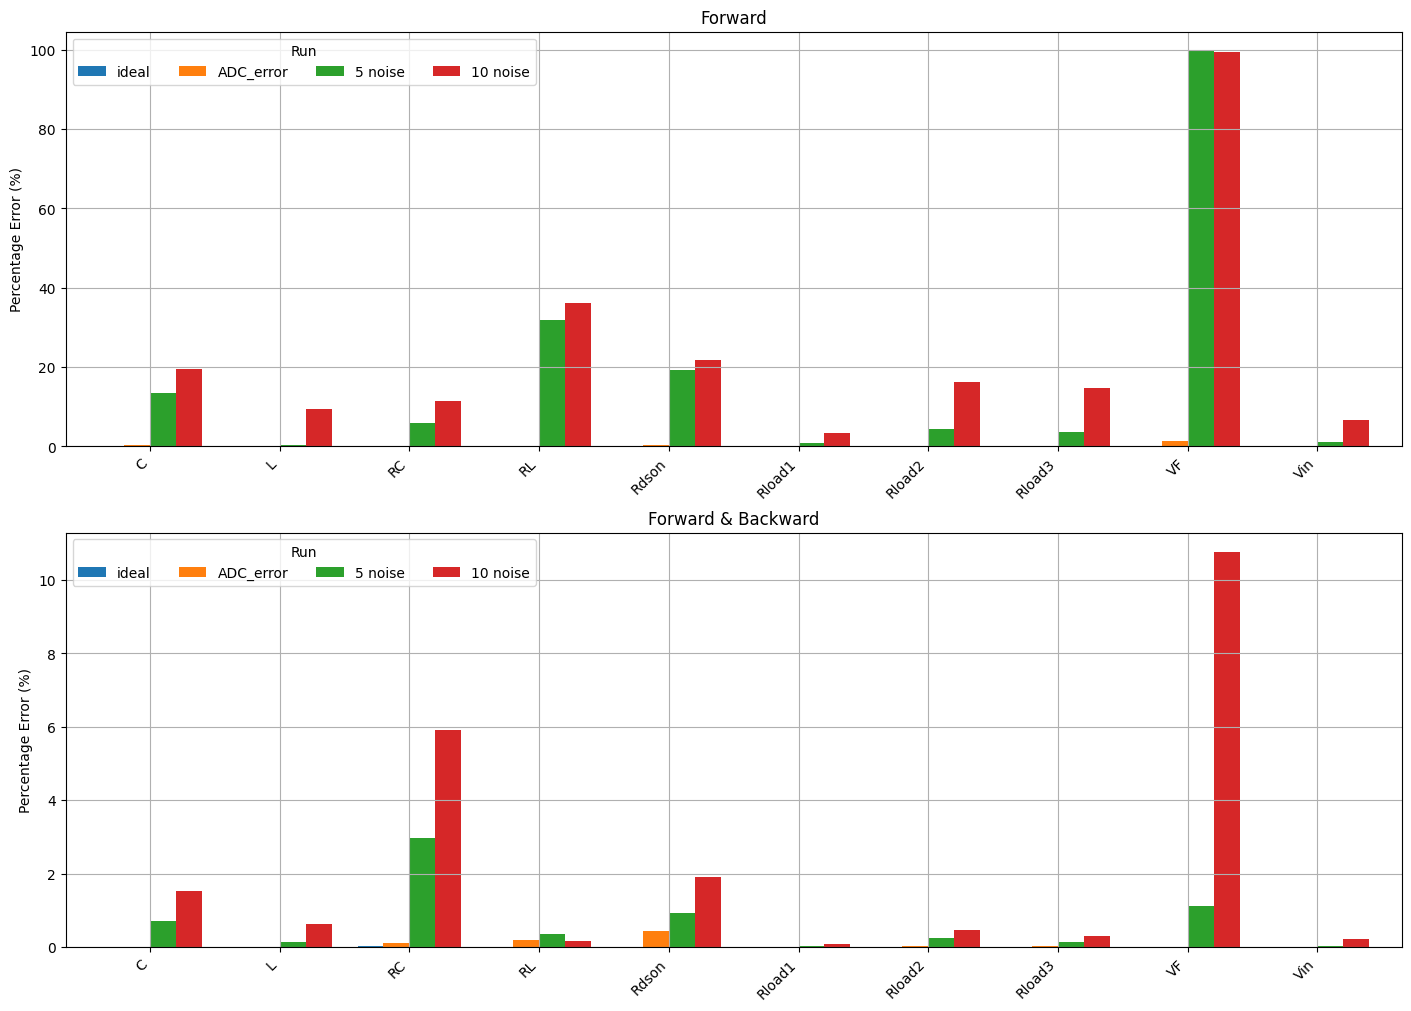

In [6]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
fb_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward&backward"
)
fbm_outdir = (
    Path.cwd().parent
    / "RESULTS"
    / "Testing"
    / "forward_vs_forward&backward"
    / "f&b_matrix_loss_form"
)


csv_files = list(fbm_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "fbm_" + label
    if ii == 0:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_fbm = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


csv_files = list(fb_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "f&b_" + label
    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None, linestyle="--")

runs_ordered_fb = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


fig, ax = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_fbm, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[0]
)
plot_final_percentage_error_multi(
    runs=runs_ordered_fb, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[1]
)

ax[0].set_title("Forward")
ax[1].set_title("Forward & Backward")

## Why ADAM fails with the full covariance matrix?

---

### Chapter: Why Adam Fails with Full-Covariance Mahalanobis Loss

#### 🧭 1. Background: Preconditioning and Curvature

In optimization, a **preconditioner** $P$ is used to transform gradients before stepping, effectively rescaling the loss landscape to reduce condition number and accelerate convergence. In quadratic minimization, the ideal preconditioner is $H^{-1}$, the inverse Hessian. Preconditioned gradient descent then becomes:

$$\theta_{t+1} = \theta_t - \eta P \nabla \mathcal{L}(\theta_t)$$

resulting in spherical level curves and stable convergence **if** $P\approx H^{-1}$.

---

#### 2. Adam’s Diagonal-Only Preconditioner

Adam adapts learning rates per-parameter using first and second moment estimates:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, \quad
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2,$$

with update:

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}.$$

Here, the preconditioner $P_t^{-1} = \eta\,\operatorname{diag}(1/\sqrt{v_t+\epsilon})$ is **diagonal**, i.e., Adam rescales each parameter independently.

---

#### 3. The Problem: Full-Covariance Loss Requires a Full Preconditioner

When using a **full covariance Mahalanobis loss**

$$\mathcal{L}(\theta) = \tfrac{1}{2}\sum_n r_n(\theta)^\top \Sigma_r^{-1} r_n(\theta),$$

the Hessian becomes

$$H = \sum_n J_n^\top \Sigma_r^{-1} J_n,$$

where $J_n$ is the Jacobian of the residuals. Since $\Sigma_r^{-1}$ contains off-diagonal blocks, $H$ becomes **rotated**—its eigenvectors don’t align with parameter axes.

Because Adam only applies diagonal scaling, it fails to align with these rotated eigenvectors. As a result:

* In directions with **high curvature**, Adam overshoots, causing divergence.
* In directions with **low curvature**, Adam undershoots, stalling progress.

This mismatch between the optimizer’s axis-aligned scaling and the true anisotropic loss landscape leads to instability.

---

### Detailed illustration with Toy Example - Hessian Rotation explained

Consider a two–parameter toy model

$$
\theta=(a,b), \qquad r(\theta)=\begin{bmatrix}a\\[2pt] b\end{bmatrix}.
$$

The Mahalanobis loss is

$$
\boxed{\;\mathcal{L}(a,b)=\tfrac12\,r^\top \Sigma^{-1} r\;}.
$$

---

#### a. Diagonal precision ( $\Sigma^{-1}=I$ )

**Loss**

$$
\mathcal{L}_{\text{diag}}=\tfrac12\,(a^{2}+b^{2}).
$$

**Gradient**

$$
\nabla\mathcal{L}_{\text{diag}}
      =\begin{bmatrix}a\\[2pt]b\end{bmatrix}.
$$

Each component depends *only* on its own coordinate:
 • changing $a$ leaves $\partial\mathcal L/\partial b$ unchanged, and vice-versa.
Hence the gradient vector points along the coordinate axes: for fixed $b$ we move purely in the $a$-direction, etc.

**Hessian**

$$
H_{\text{diag}}
      =\begin{pmatrix}1&0\\0&1\end{pmatrix}.
$$

Eigenvectors are exactly the parameter axes
$e_a=(1,0)^\top,\;e_b=(0,1)^\top$.
Adam’s diagonal preconditioner matches this geometry perfectly.

---

#### b. Full precision with correlation ( $\Sigma^{-1}=\begin{smallmatrix}1&\rho\\ \rho&1\end{smallmatrix}$, $\rho=0.9$ )

**Loss**

$$
\mathcal{L}_{\text{full}}
  =\tfrac12\bigl(a^{2}+b^{2}+2\rho\,ab\bigr).
$$

**Gradient**

$$
\nabla\mathcal{L}_{\text{full}}
  =\begin{bmatrix}
     a+\rho\,b\\
     b+\rho\,a
    \end{bmatrix}.
$$

Each partial derivative now couples both coordinates.
For example, the $a$-component is $a+\rho\,b$; if $b\neq 0$ the gradient for $a$ already has a “tilt” proportional to $b$.
Thus the gradient direction is **not aligned** with the axes unless $b=0$.

**Hessian**

$$
H_{\text{full}}
      =\begin{pmatrix}1&\rho\\[2pt]\rho&1\end{pmatrix}.
$$

Compute its eigen-decomposition:

* Eigenvalues
  $\lambda_{1}=1+\rho,\quad\lambda_{2}=1-\rho$.
* Orthogonal eigenvectors

$$
v_{1}=\tfrac{1}{\sqrt2}\begin{bmatrix}1\\1\end{bmatrix},
\quad
v_{2}=\tfrac{1}{\sqrt2}\begin{bmatrix}1\\-1\end{bmatrix}.
$$

Both eigenvectors are **rotated ± 45°** relative to the parameter axes.
Minimising the quadratic ideally moves along $v_1$ (steep) and $v_2$ (shallow).

---

#### c. Why Adam’s update becomes inefficient

Adam rescales each coordinate independently:

$$
\theta_{t+1}
  =\theta_t-\eta\,D^{-1}\,\nabla\mathcal{L}(\theta_t),
\qquad
D=\operatorname{diag}\!\bigl(\sqrt{v_t}+\varepsilon\bigr).
$$

No off-diagonal terms ⇒ **no rotation of the gradient**.
In the full-Σ case:

* Along the steep direction $v_1$: components on $a$ and $b$ must be updated **together** to descend. Adam scales them separately, so one coordinate often overshoots, the other undershoots.
* Along the shallow direction $v_2$: Adam’s per-coordinate learning rate is too small, progress slows dramatically.

The mismatch between $D^{-1}$ (axis-aligned) and $H_{\text{full}}^{-1}$ (rotated) creates oscillations or divergence, observed as a rising loss after the switch.

---

#### Takeaway

* **Diagonal Σ** → Hessian is diagonal → gradient and eigenvectors align with parameter axes → Adam works.
* **Full Σ with off-diagonal ρ** → Hessian eigenvectors are rotated → Adam’s diagonal preconditioner cannot align → optimisation becomes unstable.

For such full-covariance losses we need either
(1) a **full preconditioner** (whitening, LBFGS, K-FAC) or
(2) a gradual blend from diagonal to full covariance, or
(3) keep Adam for MAP, then apply a Laplace/posterior step with the full $\Sigma$.




#### Experiments Show Adam Struggles on Non-Diagonal Hessians

Theoretical analysis confirms that Adam’s convergence depends on both condition number $\kappa(H)$ and the degree of non-diagonality. The effective condition number becomes $\min(d,\kappa)$ in simple cases, but performs poorly when the Hessian is highly non-diagonal ([arXiv][3]). Empirical reports also show Adam can even diverge on certain convex problems due to this limitation ([Massachusetts Institute of Technology][6]).

---

#### 5. Conclusion and Implications

|                   | Block‐Diagonal Loss      | Full Covariance Loss |
| ----------------- | ------------------------ | -------------------- |
| Hessian Alignment | ≈ diagonal               | Strongly rotated     |
| Adam’s Scaling    | ✅ Good fit               | ❌ Poor fit           |
| Result            | Stable, fast convergence | Potential divergence |

Thus, switching abruptly to full covariance loss while using Adam invites failure. To succeed, we need:

* A **full preconditioner** (e.g., LBFGS, K-FAC, or whitening via Cholesky)
* Or a **staggered approach**: start with a diagonal loss and transition gradually
* Or post-train uncertainty methods like Laplace fitting **after** stable convergence

In summary, **Adam's diagonal scaling is fundamentally misaligned with rotated, full-covariance loss landscapes**, making it an unsuitable optimizer once off-diagonal covariance terms are introduced.





## LBFGS Might Work

* **How it works** LBFGS stores the most recent $m$ pairs of parameter displacements $s_k=\theta_{k+1}-\theta_k$ and gradient differences $y_k=g_{k+1}-g_k$.
  Using these pairs it builds a low-rank approximation $H_k^{-1}$ to the inverse Hessian that satisfies

  $$
  H_k^{-1} y_k = s_k \quad\text{(secant condition)}.
  $$
* **Why it helps** Although the memory size $m$ is small (e.g. 10–20), the matrix $H_k^{-1}$ is **dense** in the sub-space spanned by recent updates.  This captures **cross-parameter curvature** ignored by Adam.  Consequently, LBFGS produces steps that are automatically rotated into the valley directions of the Mahalanobis loss, reducing overshoot and speeding convergence.
* **Practical note** LBFGS uses line search (or a trust region) that adapts step length to local curvature, further mitigating divergence in steep directions.


#### Advantages

1. **Curvature matching** – LBFGS supplies a preconditioner $P$ that better approximates $H^{-1}$.
2. **Rotated updates** – Off-diagonal information lets the optimizer move simultaneously along coupled parameters, following the true valley floor.
3. **Condition-number reduction** – Effective condition number after preconditioning is $\kappa(PH)\ll\kappa(H)$, so step sizes need not shrink catastrophically.
4. **Less manual tuning** – Because the step is curvature-aware, aggressive learning-rate decay after introducing the full $\Sigma_r$ is often unnecessary.

In short, LBFGS supplies a **data-driven dense inverse-Hessian estimate** in low memory.


Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv


Text(0.5, 1.0, 'Forward & Backward with LFBGS')

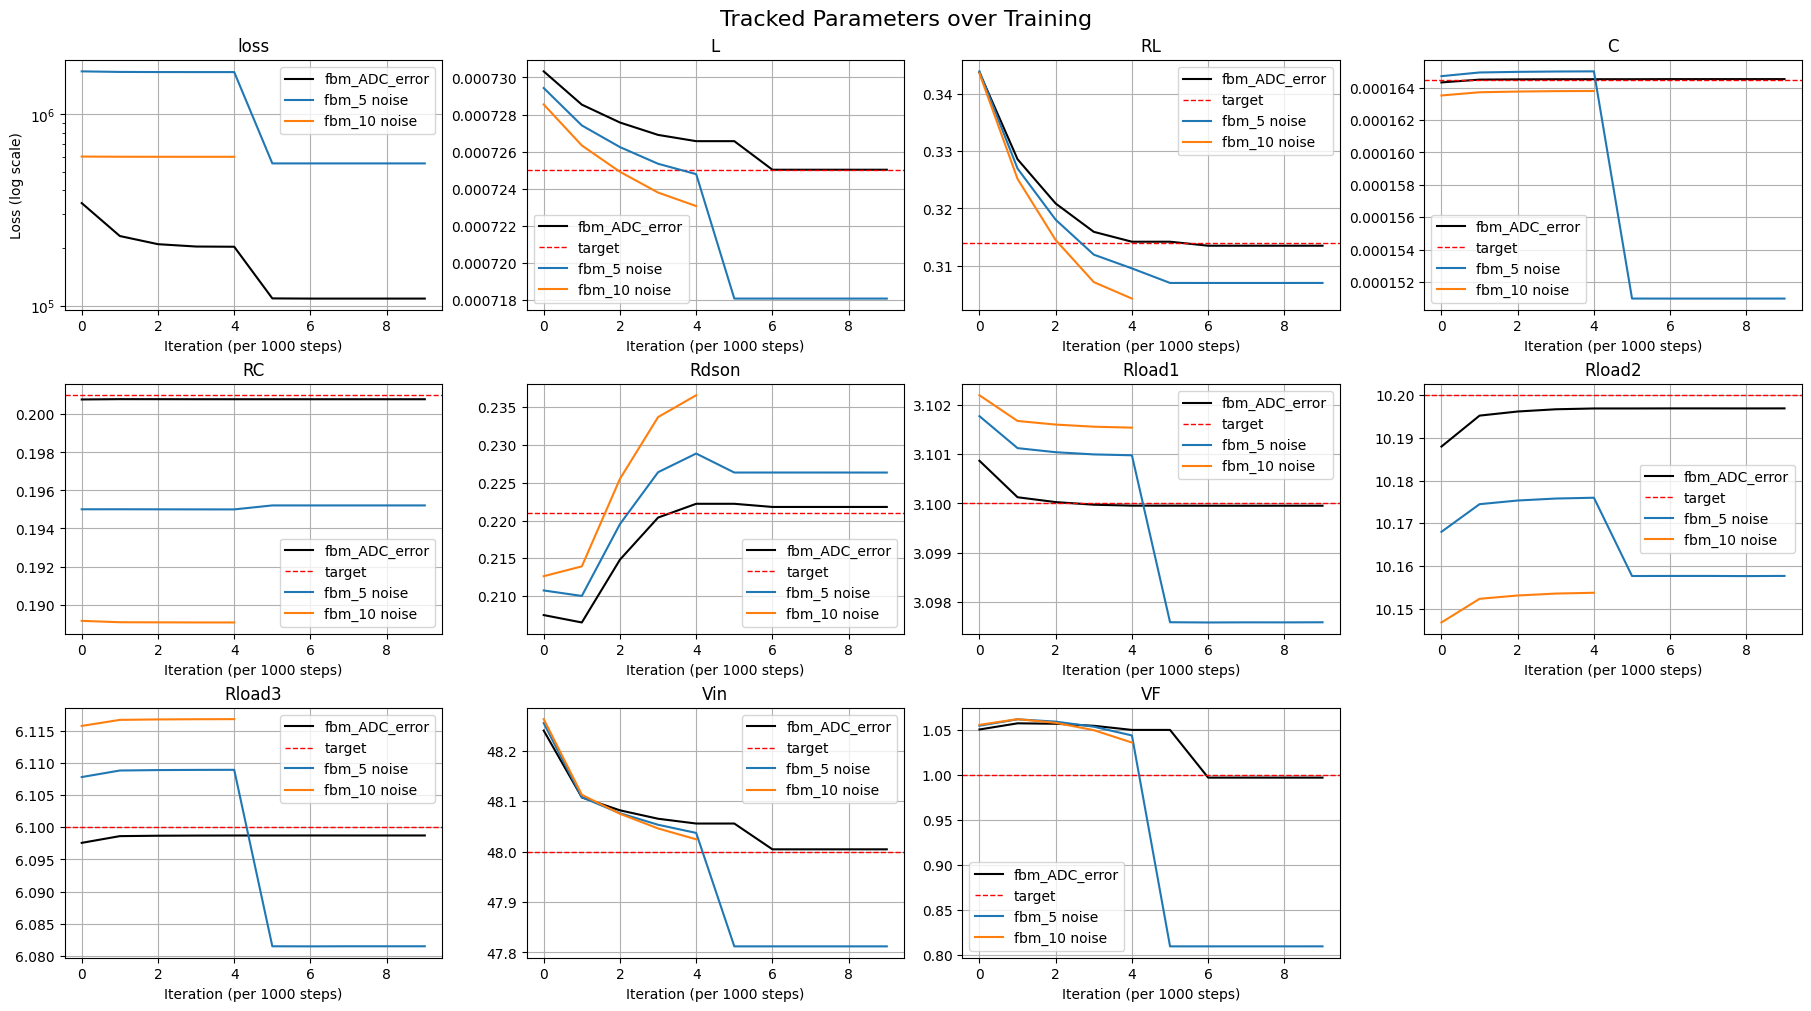

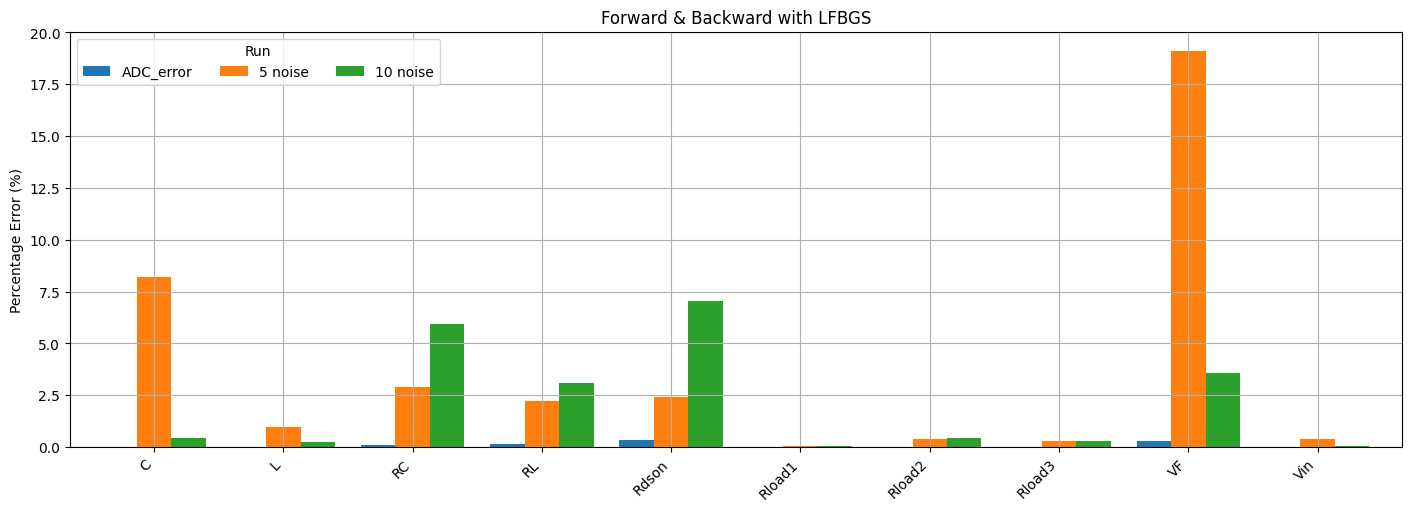

In [7]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

fbm_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "f&b_with_LBFGS"
)


csv_files = list(fbm_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "fbm_" + label
    if ii == 1:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_fbm = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (1, 3, 4)}


fig, ax = plt.subplots(figsize=(14, 5), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_fbm, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax
)


ax.set_title("Forward & Backward with LFBGS")

## Block-Diagonalized Covariance vs Full Covariance Fitting

In [8]:
from typing import Callable, Union, Iterable
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from contextlib import contextmanager
import math

# let's define a function to convert relative tolerances to standard deviations
# using the log-normal distribution assumption.
# Previously, we assumed sigma = log(1 + rel_tol). This means we assume that the relative toleraces contain 1 standard deviation
# of the data. Although usually the relative tolerances are defined as 2 or 3 standard deviations, we will use 1 standard deviation
# since this is the worst case scenario.


def rel_tolerance_to_sigma(rel_tol: Parameters) -> Parameters:
    """Convert relative tolerances to standard deviations."""

    def _to_sigma(value: float) -> torch.Tensor:
        """Convert a relative tolerance to standard deviation."""
        return torch.log(torch.tensor(1 + value, dtype=torch.float32))

    return Parameters(
        L=_to_sigma(rel_tol.L),
        RL=_to_sigma(rel_tol.RL),
        C=_to_sigma(rel_tol.C),
        RC=_to_sigma(rel_tol.RC),
        Rdson=_to_sigma(rel_tol.Rdson),
        Rload1=_to_sigma(rel_tol.Rload1),
        Rload2=_to_sigma(rel_tol.Rload2),
        Rload3=_to_sigma(rel_tol.Rload3),
        Vin=_to_sigma(rel_tol.Vin),
        VF=_to_sigma(rel_tol.VF),
    )


# define the log-normal prior for the parameters assuming independent priors distrubuted according to the log-normal distribution.
# See the formula above.
def log_normal_prior(logparams: Parameters, nominal: Parameters, sigma: Parameters) -> torch.Tensor:
    """Return −log p(log z) assuming independent log-normal priors."""
    total = 0.0
    nominal_logparams = make_log_param(nominal)
    for name in Parameters._fields:
        proposed_value = getattr(logparams, name)
        mu = getattr(nominal_logparams, name)
        sig = getattr(sigma, name)
        total += ((proposed_value - mu) / sig) ** 2 / 2
    return total


def ensure_positive_definite(Sigma: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Ensure the Sigma matrix is positive definite by adding a small value to the diagonal.
    """
    return Sigma + torch.eye(Sigma.shape[0], device=Sigma.device) * eps


def noise_power_to_sigma(
    noise_power_i: float,
    noise_power_v: float,
) -> torch.Tensor:

    return torch.tensor(
        [[noise_power_i, 0.0], [0.0, noise_power_v]],
        dtype=torch.float32,
    )


def estimate_Sigma_r_2x2_blocks(sigma_x: torch.Tensor, J: torch.Tensor) -> torch.Tensor:
    """
    Estimate the Sigma matrix for the 2x2 blocks.
    This function assumes that sigma_x is a 2x2 matrix and J is a 2x2 matrix.
    """
    if sigma_x.shape != (2, 2):
        raise ValueError("sigma_x must be a 2x2 matrix.")
    if J.shape != (2, 2):
        raise ValueError("J must be a 2x2 matrix.")

    J_inv = torch.linalg.inv(J)

    # Calculate the Sigma matrix for the 2x2 blocks
    Sigma_fwfw = J @ sigma_x @ J.T + sigma_x
    Sigma_fwbw = -J @ sigma_x - sigma_x @ J_inv.T
    Sigma_bwfw = -J_inv @ sigma_x - sigma_x @ J.T
    Sigma_bwbw = J_inv @ sigma_x @ J_inv.T + sigma_x

    return {
        "fwfw": Sigma_fwfw,
        "fwbw": Sigma_fwbw,
        "bwfw": Sigma_bwfw,
        "bwbw": Sigma_bwbw
    }


def estimate_sigma_fw_bw(
    sigma_x: torch.Tensor,
    J: torch.Tensor,
    calculate_diag_terms: bool = True,
):
    # def helper_diag_terms(
    #     sigma_x: torch.Tensor,
    #     J: torch.Tensor,
    # ) -> torch.Tensor:
    #     """
    #     Helper function to compute the diagonal terms of the Sigma matrix.
    #     """
    #     return J @ sigma_x @ J.T + sigma_x

    # j_inv: torch.Tensor = torch.linalg.inv(J)

    # if calculate_diag_terms:
    #     sig_12 = -J @ sigma_x - sigma_x @ j_inv.T
    #     sig_21 = -j_inv @ sigma_x - sigma_x @ J.T

    # else:
    #     sig_12 = torch.zeros((2, 2), device=sigma_x.device)
    #     sig_21 = torch.zeros((2, 2), device=sigma_x.device)

    sigma_blocks = estimate_Sigma_r_2x2_blocks(sigma_x, J)

    # build the 4x4 Sigma matrix
    Sigma = torch.zeros((4, 4), device=sigma_x.device)
    Sigma[:2, :2] = sigma_blocks["fwfw"]  # top-left
    Sigma[2:, 2:] = sigma_blocks["bwbw"]  # bottom-right
    
    if calculate_diag_terms:
        Sigma[:2, 2:] = sigma_blocks["fwbw"]  # top-right
        Sigma[2:, :2] = sigma_blocks["bwfw"]  # bottom-left
    return Sigma


def data_noise_to_sigma(
    data_noise: Union[float, Iterable, torch.Tensor], 
    jac: torch.Tensor, 
    calculate_diag_terms: bool = True,
    damp: float = 1e-8
    ) -> torch.Tensor:
    """Parse data_noise and return the inverse covariance matrix Sigma_x_inv."""
    if isinstance(data_noise, float):
        a = data_noise
        b = data_noise
    elif isinstance(data_noise, torch.Tensor):
        if data_noise.shape != (2, 2):
            raise ValueError("If data_noise is a tensor, it must be 2x2.")
        a = data_noise[0, 0]
        b = data_noise[1, 1]
    elif isinstance(data_noise, Iterable):
        data_noise = list(data_noise)
        if len(data_noise) != 2:
            raise ValueError("If data_noise is iterable, it must be of length 2.")
        a = data_noise[0]
        b = data_noise[1]
    else:
        raise TypeError("data_noise must be float, 2-tensor, or iterable of length 2.")

    sigma_x = torch.diag(torch.tensor([a, b], dtype=torch.float32))
    sigma_r =  estimate_sigma_fw_bw(
        sigma_x=sigma_x,
        J=jac,
        calculate_diag_terms=calculate_diag_terms,
    )

    # ensure the Sigma matrix is positive definite
    sigma_r = ensure_positive_definite(sigma_r, eps=damp)
    return sigma_r

def chol_inv(mat: torch.Tensor, eps=1e-9) -> torch.Tensor:
    """return (LLᵀ)⁻¹ᐟ² = L⁻ᵀ   where LLᵀ = mat (add jitter if needed)"""
    mat = mat + eps * torch.eye(mat.size(0), device=mat.device)
    L = torch.linalg.cholesky(mat)
    return torch.cholesky_inverse(L)  # same as L⁻ᵀ · L⁻¹

def chol(mat: torch.Tensor, eps=1e-9) -> torch.Tensor:
    """return L where LLᵀ = mat (add jitter if needed)"""
    mat = mat + eps * torch.eye(mat.size(0), device=mat.device)
    L = torch.linalg.cholesky(mat)
    return L  # same as L⁻ᵀ · L⁻¹




def fw_bw_loss_whitened(
    pred_np1: torch.Tensor,
    pred_n: torch.Tensor,
    observations_np1: torch.Tensor,
    observations_n: torch.Tensor,
    L: torch.Tensor,
) -> torch.Tensor:
    """
    Compute r^T Σ^{-1} r via Cholesky whitening: r -> z = L^{-1} r.
    """
    residual_np1 = pred_np1 - observations_np1  # shape (batch_size, 2)
    residual_n = pred_n - observations_n  # shape (batch_size, 2)
    r = torch.cat((residual_np1, residual_n), dim=1)  # (B, 4)
    z = torch.linalg.solve_triangular(L, r.T, upper=False).T  # shape [N, 4]
    ## IMPORTANT NOTE:
    # Note that using solve_triangular is much more stable for the gradients and optimization
    # compared to z = torch.matmul(r, L_inv.T)  # whitening: (B, 4)
    # even if L_inv = chol_inv(L) is used, it is still more stable to use solve_triangular
    # because it avoids the numerical issues with the inverse of the Cholesky factor.
    return 0.5 * (z**2).sum()


# define the loss function for MAP estimation that combines the L2 loss and the log-normal prior.
def make_map_loss(
    nominal: Parameters, sigma0: Parameters, L: torch.Tensor, scale_factor: float = 1.0
) -> Callable:

    def _loss(logparams: Parameters, preds, targets):
        i_np, v_np, i_np1, v_np1 = preds
        y_n, y_np1 = targets
        pred_n = torch.cat((i_np, v_np), dim=1)
        pred_np1 = torch.cat((i_np1, v_np1), dim=1)
        ll = fw_bw_loss_whitened(pred_n=pred_n, pred_np1=pred_np1, observations_n=y_n, observations_np1=y_np1, L=L)
        prior = log_normal_prior(logparams, nominal, sigma0)
        map_loss = ll + prior
        return map_loss * scale_factor
        

    return _loss

In [9]:
from dataclasses import dataclass


# for simplicity let's define a dataclass for the training configurations
@dataclass
class AdamOptTrainingConfigs:
    savename: str = "saved_run"
    out_dir: Path = Path(".")
    lr: float = 1e-3
    epochs: int = 20_000
    device: str = "cpu"
    patience: int = 5000
    lr_reduction_factor: float = 0.5
    epochs_lbfgs: int = 1500
    lr_lbfgs: float = 1e-3
    history_size_lbfgs: int = 50
    max_iter_lbfgs: int = 10
    clip_gradient_adam: float = None
    save_every_adam: int = 1000
    save_every_lbfgs: int = 10


class NormalizerMeanStd:
    """A simple normalizer that normalizes the data using mean and standard deviation."""

    def __init__(self, x: torch.Tensor):
        """Initialize the normalizer with the mean and standard deviation of the data."""
        self.mean = x.mean(dim=0, keepdim=True)
        self.std = x.std(dim=0, keepdim=True)
    
    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        """Normalize the data."""
        return (x - self.mean) / self.std
    def normalize_current(self, i: torch.Tensor) -> torch.Tensor:
        """Normalize the current data."""
        return (i - self.mean[:, 0]) / self.std[:, 0]
    def normalize_voltage(self, v: torch.Tensor) -> torch.Tensor:
        """Normalize the voltage data."""
        return (v - self.mean[:, 1]) / self.std[:, 1]
    
    def denormalize(self, x: torch.Tensor) -> torch.Tensor:
        """Denormalize the data."""
        return x * self.std + self.mean
    
    def denormalize_current(self, i: torch.Tensor) -> torch.Tensor:
        """Denormalize the current data."""
        return i * self.std[:, 0] + self.mean[:, 0]
    def denormalize_voltage(self, v: torch.Tensor) -> torch.Tensor:
        """Denormalize the voltage data."""
        return v * self.std[:, 1] + self.mean[:, 1]
    
    def normalize_model_predictions(
        self, preds: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Normalize the model predictions."""
        i_pn, v_pn, i_pnp1, v_pnp1 = preds
        return (
            self.normalize_current(i_pn),
            self.normalize_voltage(v_pn),
            self.normalize_current(i_pnp1),
            self.normalize_voltage(v_pnp1),
        )
    def denormalize_model_predictions(
        self, preds: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Denormalize the model predictions."""
        i_pn, v_pn, i_pnp1, v_pnp1 = preds
        return (
            self.denormalize_current(i_pn),
            self.denormalize_voltage(v_pn),
            self.denormalize_current(i_pnp1),
            self.denormalize_voltage(v_pnp1),
        )
    
    def normalize_y(
        self, y: torch.Tensor
    ) -> torch.Tensor:
        """Normalize the output data."""
        return (y - self.mean) / self.std


class Trainer:

    def __init__(
        self,
        model: BuckParamEstimator,
        loss_fn: Callable,
        optim_cfg: AdamOptTrainingConfigs,
        lbfgs_loss_fn: Callable = None,
        device="cpu",
    ):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.lbfgs_loss_fn = lbfgs_loss_fn if lbfgs_loss_fn is not None else loss_fn
        self.optim_cfg = optim_cfg
        self.device = device
        self.history = {"loss": [], "params": [], "lr": []}

    def fit(self, X, y, normalize_input: bool = True):
        X = X.detach().to(self.device)
        y = y.detach().to(self.device)
        y_prev = X[:, :2].clone().detach().to(self.device)

        X = X.to(self.device)
        y = y.to(self.device)
        y_prev = y_prev.to(self.device)

        opt = torch.optim.Adam(self.model.parameters(), lr=self.optim_cfg.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            mode="min",
            factor=self.optim_cfg.lr_reduction_factor,
            patience=self.optim_cfg.patience,
        )

        # Initialize the best loss
        best_loss = float("inf")

        if normalize_input:
            # normalize on the i and v of the input
            normalizer = NormalizerMeanStd(X[:, :2])        
            y_prev_norm = normalizer.normalize(y_prev)
            y_norm = normalizer.normalize(y)
        else:
            # no normalization
            y_prev_norm = y_prev
            y_norm = y

        for it in range(1, self.optim_cfg.epochs + 1):
            opt.zero_grad()
            preds = normalizer.normalize_model_predictions(self.model(X, y)) if normalize_input else self.model(X, y)

            loss: torch.Tensor = self.loss_fn(self.model.logparams, preds, (y_prev_norm, y_norm))
            loss.backward()

            if self.optim_cfg.clip_gradient_adam is not None:
                # Clip gradients to prevent exploding gradients
                old_gr = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.optim_cfg.clip_gradient_adam)                                                      

            opt.step()
            scheduler.step(loss.item())

            if it % 1000 == 0:
                est = self.model.get_estimates()
                if loss.item() < best_loss:
                    best_loss = loss.item()

                # print the parameter estimation
                grads = [
                    getattr(self.model, f"log_{n}").grad.view(1)
                    for n in Parameters._fields
                    if getattr(self.model, f"log_{n}").grad is not None
                ]

                if grads:
                    gradient_vector = torch.cat(grads)
                    gradient_norm = gradient_vector.norm().item()
                else:
                    gradient_norm = float(
                        "nan"
                    )  # no gradients found (shouldn't happen during training)

                print(
                    f"[Adam] Iteration {it}, gradient_norm {gradient_norm:4e}, loss {loss:4e},  Parameters:",
                    f"L={est.L:.3e}, RL={est.RL:.3e}, C={est.C:.3e}, "
                    f"RC={est.RC:.3e}, Rdson={est.Rdson:.3e}, "
                    f"Rload1={est.Rload1:.3e}, Rload2={est.Rload2:.3e}, "
                    f"Rload3={est.Rload3:.3e}, Vin={est.Vin:.3f}, VF={est.VF:.3e}",
                )

            if it % self.optim_cfg.save_every_adam == 0:
                est = self.model.get_estimates()
                # update the histories with the last Adam iteration
                self.history["loss"].append(loss.item())
                self.history["params"].append(est)
                self.history["lr"].append(opt.param_groups[0]["lr"])

        # # → LBFGS
        # LBFGS optimization tends to find stable solutions that also minimize the gradient norm.
        # This will be useful when we want to compute the Laplace posterior, which relies on the Hessian of the loss function.

        lbfgs_optim = torch.optim.LBFGS(
            self.model.parameters(),
            lr=self.optim_cfg.lr_lbfgs,
            max_iter=self.optim_cfg.max_iter_lbfgs,  # inner line-search iterations
            history_size=self.optim_cfg.history_size_lbfgs,  # critical for stability
        )

        nan_abort = True  # raise RuntimeError on NaN/Inf

        # ------------------------------------------------------------------
        #  Closure with finite checks
        # ------------------------------------------------------------------
        def closure():
            lbfgs_optim.zero_grad()

            pred = self.model(X, y)
            pred_norm = normalizer.normalize_model_predictions(pred) if normalize_input else pred
            loss_val = self.lbfgs_loss_fn(
                self.model.logparams, pred_norm, (y_prev_norm, y_norm)
            )

            # 1)  finite-loss check
            if not torch.isfinite(loss_val):
                message = "[LBFGS] Non-finite loss encountered"
                if nan_abort:
                    raise RuntimeError(message)
                else:
                    print(message)
                    return loss_val
            # 2)  clip gradients to prevent exploding gradients
            loss_val.backward()

            return loss_val

        # ------------------------------------------------------------------
        #  LBFGS training loop
        # ------------------------------------------------------------------
        for it in range(1, self.optim_cfg.epochs_lbfgs+1):
            try:
                loss = lbfgs_optim.step(closure)
            except RuntimeError as err:
                print(f"[LBFGS] Stopped at outer iter {it}: {err}")
                break

            # 3)  post-step parameter sanity
            with torch.no_grad():
                if any(not torch.isfinite(p).all() for p in self.model.parameters()):
                    print("[LBFGS] Non-finite parameter detected — aborting.")
                    break

            if it % 100 == 0:
                est = self.model.get_estimates()

                if loss.item() < best_loss:
                    best_loss = loss.item()

                # print the parameter estimation
                grads = [
                    getattr(self.model, f"log_{n}").grad.view(1)
                    for n in Parameters._fields
                    if getattr(self.model, f"log_{n}").grad is not None
                ]

                if grads:
                    gradient_vector = torch.cat(grads)
                    gradient_norm = gradient_vector.norm().item()
                else:
                    gradient_norm = float(
                        "nan"
                    )  # no gradients found (shouldn't happen during training)

                print(
                    f"[LBFGS] Iteration {self.optim_cfg.epochs + it}, gradient_norm {gradient_norm:4e}, loss {loss:4e},  Parameters:",
                    f"L={est.L:.3e}, RL={est.RL:.3e}, C={est.C:.3e}, "
                    f"RC={est.RC:.3e}, Rdson={est.Rdson:.3e}, "
                    f"Rload1={est.Rload1:.3e}, Rload2={est.Rload2:.3e}, "
                    f"Rload3={est.Rload3:.3e}, Vin={est.Vin:.3f}, VF={est.VF:.3e}",
                )

            if it % self.optim_cfg.save_every_lbfgs == 0:
                est = self.model.get_estimates()
                # update the histories with the last BFGS iteration
                self.history["loss"].append(loss.item())
                self.history["params"].append(est)
                self.history["lr"].append(opt.param_groups[0]["lr"])

        # Save the history to a CSV file
        training_run = TrainingRun.from_histories(
            loss_history=self.history["loss"],
            param_history=self.history["params"],
        )

        # generate the output directory if it doesn't exist
        self.optim_cfg.out_dir.mkdir(parents=True, exist_ok=True)

        # if savename doesn't end with .csv, add it
        savename = self.optim_cfg.savename

        if not savename.endswith(".csv"):
            savename += ".csv"

        training_run.save_to_csv(self.optim_cfg.out_dir / savename)
        print("Concluded training.")

        print("Training completed successfully.")
        print(f"Best loss: {best_loss:.4e}")
        best_params = training_run.best_parameters
        opt_model = BuckParamEstimator(
            lower_bound = self.model.lb,
            upper_bound = self.model.ub,
            split1= self.model.s1,
            split2= self.model.s2,
            split3= self.model.s3,
            param_init = best_params,
        )

        self.training_run = training_run
        self.opt_model = opt_model

        return opt_model

In [10]:
## Noise Power
lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2


# LOAD THE PRECOMPUTED JACOBIAN
jacobian_dir = Path.cwd().parent / "RESULTS" / "Jacobains" / "N0"
J_av = torch.load(jacobian_dir / "jacobian.pt")


# Generate the Sigma matrix for the noise power
sigma_adc = data_noise_to_sigma(
    data_noise = (noise_power_ADC_i, noise_power_ADC_v),
    jac=J_av,
    calculate_diag_terms=False,
    damp = 1e-7
)

sigma_5 = data_noise_to_sigma(
    data_noise = (noise_power_5_i, noise_power_5_v),
    jac=J_av,
    calculate_diag_terms=False,
    damp = 1e-7
)

sigma_10 = data_noise_to_sigma(
    data_noise = (noise_power_10_i, noise_power_10_v),
    jac=J_av,
    calculate_diag_terms=False,
    damp = 1e-7
)


print(f"Sigma matrix for ADC noise:\n{sigma_adc}")
print(f"Sigma matrix for 5 LSB noise:\n{sigma_5}")
print(f"Sigma matrix for 10 LSB noise:\n{sigma_10}")


L_inv_adc = chol_inv(sigma_adc)
L_inv_5 = chol_inv(sigma_5)
L_inv_10 = chol_inv(sigma_10)

L_adc = chol(sigma_adc)
L_5 = chol(sigma_5)
L_10 = chol(sigma_10)


Sigma matrix for ADC noise:
tensor([[ 1.1829e-05, -9.4804e-07,  0.0000e+00,  0.0000e+00],
        [-9.4804e-07,  1.0166e-04,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.2313e-05,  1.2122e-06],
        [ 0.0000e+00,  0.0000e+00,  1.2122e-06,  1.1356e-04]])
Sigma matrix for 5 LSB noise:
tensor([[ 2.9333e-04, -2.3701e-05,  0.0000e+00,  0.0000e+00],
        [-2.3701e-05,  2.5391e-03,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  3.0543e-04,  3.0306e-05],
        [ 0.0000e+00,  0.0000e+00,  3.0306e-05,  2.8366e-03]])
Sigma matrix for 10 LSB noise:
tensor([[ 1.1730e-03, -9.4804e-05,  0.0000e+00,  0.0000e+00],
        [-9.4804e-05,  1.0156e-02,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.2214e-03,  1.2122e-04],
        [ 0.0000e+00,  0.0000e+00,  1.2122e-04,  1.1346e-02]])


In [11]:
damp = 1e-5

sigma_adc_full = data_noise_to_sigma(
    data_noise = (noise_power_ADC_i, noise_power_ADC_v),
    jac=J_av,
    calculate_diag_terms=True,
    damp = damp
)

sigma_5_full = data_noise_to_sigma(
    data_noise = (noise_power_5_i, noise_power_5_v),
    jac=J_av,
    calculate_diag_terms=True,
    damp = damp
)

sigma_10_full = data_noise_to_sigma(
    data_noise = (noise_power_10_i, noise_power_10_v),
    jac=J_av,
    calculate_diag_terms=True,
    damp = damp*10
)


print(f"Sigma matrix for ADC noise (full):\n{sigma_adc_full}")
print(f"Sigma matrix for 5 LSB noise (full):\n{sigma_5_full}")
print(f"Sigma matrix for 10 LSB noise (full):\n{sigma_10_full}")

L_inv_adc_full = chol_inv(sigma_adc_full)
L_inv_5_full = chol_inv(sigma_5_full)
L_inv_10_full = chol_inv(sigma_10_full)

L_adc_full = chol(sigma_adc_full)
L_5_full = chol(sigma_5_full)
L_10_full = chol(sigma_10_full)


frob_sigma_adc = torch.linalg.norm(sigma_adc_full, ord="fro")
frob_sigma_5 = torch.linalg.norm(sigma_5_full, ord="fro")
frob_sigma_10 = torch.linalg.norm(sigma_10_full, ord="fro")

det_sigma_adc = torch.linalg.det(sigma_adc_full)
det_sigma_5 = torch.linalg.det(sigma_5_full)
det_sigma_10 = torch.linalg.det(sigma_10_full)

print(f"Frobenius norm of Sigma for ADC noise: {frob_sigma_adc:.4e}")
print(f"Frobenius norm of Sigma for 5 LSB noise: {frob_sigma_5:.4e}")
print(f"Frobenius norm of Sigma for 10 LSB noise: {frob_sigma_10:.4e}")

print(f"Determinant of Sigma for ADC noise: {det_sigma_adc:.4e}")
print(f"Determinant of Sigma for 5 LSB noise: {det_sigma_5:.4e}")
print(f"Determinant of Sigma for 10 LSB noise: {det_sigma_10:.4e}")

Sigma matrix for ADC noise (full):
tensor([[ 2.1729e-05, -9.4804e-07, -1.1896e-05,  2.8285e-06],
        [-9.4804e-07,  1.1156e-04, -2.9097e-06, -1.0721e-04],
        [-1.1896e-05, -2.9097e-06,  2.2213e-05,  1.2122e-06],
        [ 2.8285e-06, -1.0721e-04,  1.2122e-06,  1.2346e-04]])
Sigma matrix for 5 LSB noise (full):
tensor([[ 3.0323e-04, -2.3701e-05, -2.9740e-04,  7.0712e-05],
        [-2.3701e-05,  2.5490e-03, -7.2742e-05, -2.6802e-03],
        [-2.9740e-04, -7.2742e-05,  3.1533e-04,  3.0306e-05],
        [ 7.0712e-05, -2.6802e-03,  3.0306e-05,  2.8465e-03]])
Sigma matrix for 10 LSB noise (full):
tensor([[ 1.2729e-03, -9.4804e-05, -1.1896e-03,  2.8285e-04],
        [-9.4804e-05,  1.0256e-02, -2.9097e-04, -1.0721e-02],
        [-1.1896e-03, -2.9097e-04,  1.3213e-03,  1.2122e-04],
        [ 2.8285e-04, -1.0721e-02,  1.2122e-04,  1.1446e-02]])
Frobenius norm of Sigma for ADC noise: 2.2795e-04
Frobenius norm of Sigma for 5 LSB noise: 5.4184e-03
Frobenius norm of Sigma for 10 LSB noise:

In [12]:
def blockwise_loss(
    pred_np1: torch.Tensor,
    pred_n: torch.Tensor,
    observations_np1: torch.Tensor,
    observations_n: torch.Tensor,
    Sigma: torch.Tensor,
):
    residual_np1 = pred_np1 - observations_np1  # shape (batch_size, 2)
    residual_n = pred_n - observations_n  # shape (batch_size, 2)

    Sig_fwfw = Sigma[:2, :2]
    Sig_bwbw = Sigma[2:, 2:]
    Sig_fwbw = Sigma[:2, 2:]

    L_fwfw = torch.linalg.cholesky(Sig_fwfw)
    L_bwbw = torch.linalg.cholesky(Sig_bwbw)

    z_fwfw = torch.linalg.solve_triangular(L_fwfw, residual_np1.T, upper=False).T  # shape [N, 2]
    z_bwbw = torch.linalg.solve_triangular(L_bwbw, residual_n.T, upper=False).T  # shape [N, 2]

    # Assuming Sigma_fwbw is usually not invertible
    lambda_cross = torch.mean(Sig_fwbw)  # heuristic; can be negative
    loss_cross = lambda_cross * (residual_np1 * residual_n).sum()

    return 0.5 * (z_fwfw**2).sum() + 0.5 * (z_bwbw**2).sum() + loss_cross


def make_map_loss_blockwise(
    nominal: Parameters, sigma0: Parameters, Sigma: torch.Tensor, scale_factor: float = 1.0
) -> Callable:
    """Create a loss function for MAP estimation with blockwise loss."""
    
    def _loss(logparams: Parameters, preds, targets):
        i_np, v_np, i_np1, v_np1 = preds
        y_n, y_np1 = targets
        pred_n = torch.cat((i_np, v_np), dim=1)
        pred_np1 = torch.cat((i_np1, v_np1), dim=1)
        ll = blockwise_loss(
            pred_np1=pred_np1,
            pred_n=pred_n,
            observations_np1=y_np1,
            observations_n=y_n,
            Sigma=Sigma,
        )
        prior = log_normal_prior(logparams, nominal, sigma0)
        map_loss = ll + prior
        return map_loss * scale_factor

    return _loss

In [13]:
set_seed(123)
device = "cpu"

# Load and assemble dataset
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"

out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "FullSigma_MAP1"


run_configs = AdamOptTrainingConfigs(
    savename="adam_run.csv",
    out_dir=out_dir,
    lr=1e-3,
    epochs=15_000,
    device="cpu",
    patience=3000,
    lr_reduction_factor=0.5,
    epochs_lbfgs=1_000,
    lr_lbfgs=1e-3,
    history_size_lbfgs=100,
    max_iter_lbfgs=20,
    clip_gradient_adam=1e6,  
)


# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model


l_dict = {
    1: L_adc,  # ADC error
    3: L_5,  # 5 noise
    4: L_10,  # 10 noise
}
l_dict_full = {
    1: L_adc_full,  # ADC error
    3: L_5_full,  # 5 noise
    4: L_10_full,  # 10 noise
}

S_dict_full = {
    1: sigma_adc_full,  # ADC error
    3: sigma_5_full,  # 5 noise
    4: sigma_10_full,  # 10 noise
}




noisy_measurements = {}
trained_models = {}
trained_runs = {}
inverse = False

# Load the data from the hdf5 file
io = LoaderH5(db_dir, h5filename)

for idx, group_number in enumerate(l_dict.keys()):
    group_name = GROUP_NUMBER_DICT[group_number]
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    run_configs.savename = f"noisy_run_{group_name}.csv"

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X, y, model = load_data_to_model(
        meas=io.M,
        initial_guess_params=NOMINAL,
    )

    prior_info = {
        "nominal": NOMINAL,
        "sigma0": rel_tolerance_to_sigma(REL_TOL),
    }
    
    chol_L = l_dict[group_number]  # Cholesky factor of the noise covariance matrix
    chol_L_full = l_dict_full[group_number]  # Cholesky factor of the full noise covariance matrix
    
    sig_r = S_dict_full[group_number]  # full noise covariance matrix

    trainer = Trainer(
        model=model,
        loss_fn = make_map_loss(
            **prior_info,
            L=chol_L,  # full noise covariance matrix
            scale_factor=1.0,  # scale factor for the loss
        ),
        
        # loss_fn=make_map_loss(
        #     **prior_info,
        #     L = chol_L,  # Cholesky factor of the noise covariance matrix
        # ),
        optim_cfg=run_configs,
        device=device,
        lbfgs_loss_fn=make_map_loss_blockwise(
            **prior_info,
            Sigma=sig_r,  # use the full noise power for the group
            # scale_factor=np.sqrt(scale_factor_dict[group_number]),  # scale factor for the loss
        )
    )

    opt_model = trainer.fit(
        X=X,
        y=y,
        normalize_input=False
    )
    inverse = True  # inverse is False only for the ideal case, so we set it to True for the rest of the groups
    trained_models[group_name] = opt_model
    trained_runs[group_name] = trainer.training_run
    print("\n \n \n")

Loading group 1: ADC_error

--------------------------------------------------
0) Training with ADC_error data
[Adam] Iteration 1000, gradient_norm 1.051747e+03, loss 1.537733e+02,  Parameters: L=7.286e-04, RL=3.301e-01, C=1.645e-04, RC=2.008e-01, Rdson=2.051e-01, Rload1=3.100e+00, Rload2=1.019e+01, Rload3=6.099e+00, Vin=48.111, VF=1.054e+00
[Adam] Iteration 2000, gradient_norm 2.730841e+02, loss 1.214231e+02,  Parameters: L=7.272e-04, RL=3.186e-01, C=1.645e-04, RC=2.008e-01, Rdson=2.173e-01, Rload1=3.100e+00, Rload2=1.020e+01, Rload3=6.099e+00, Vin=48.073, VF=1.054e+00
[Adam] Iteration 3000, gradient_norm 3.866734e+01, loss 1.183960e+02,  Parameters: L=7.266e-04, RL=3.145e-01, C=1.645e-04, RC=2.008e-01, Rdson=2.219e-01, Rload1=3.100e+00, Rload2=1.020e+01, Rload3=6.099e+00, Vin=48.056, VF=1.050e+00
[Adam] Iteration 4000, gradient_norm 3.581591e+01, loss 1.182933e+02,  Parameters: L=7.263e-04, RL=3.140e-01, C=1.645e-04, RC=2.008e-01, Rdson=2.223e-01, Rload1=3.100e+00, Rload2=1.020e+01, 

KeyboardInterrupt: 

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv


Text(0.5, 1.0, 'FULL')

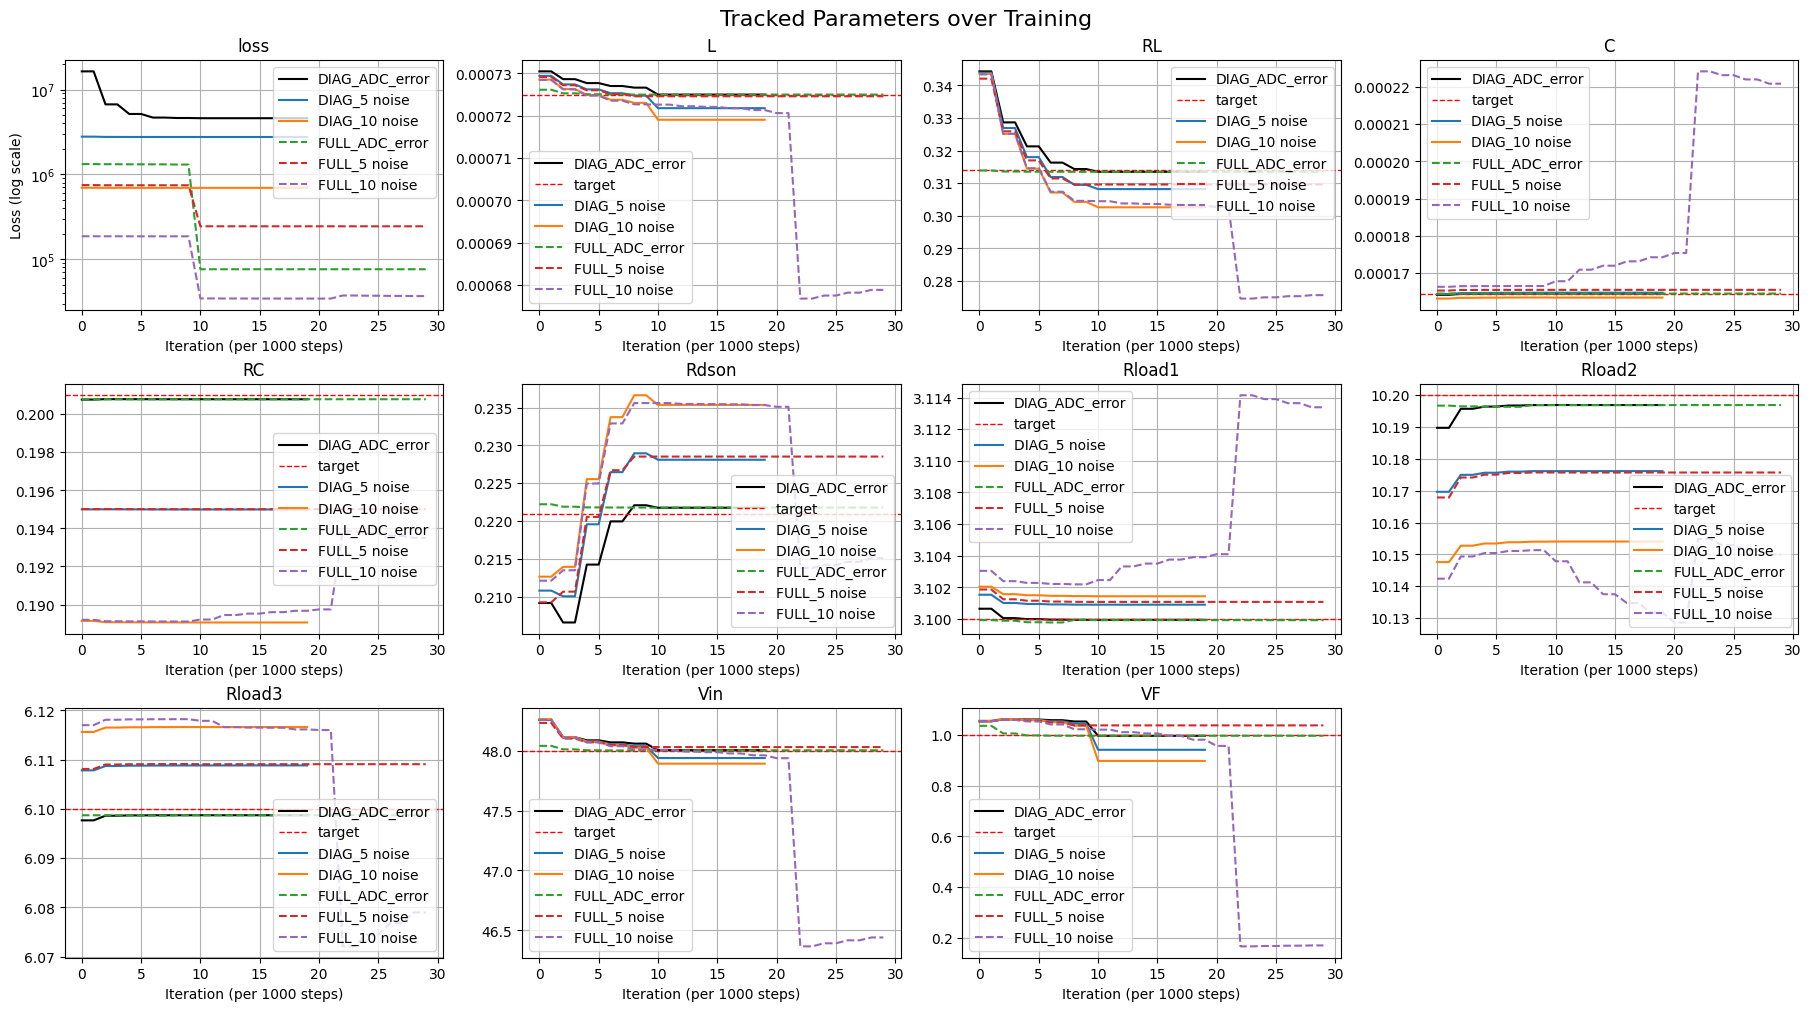

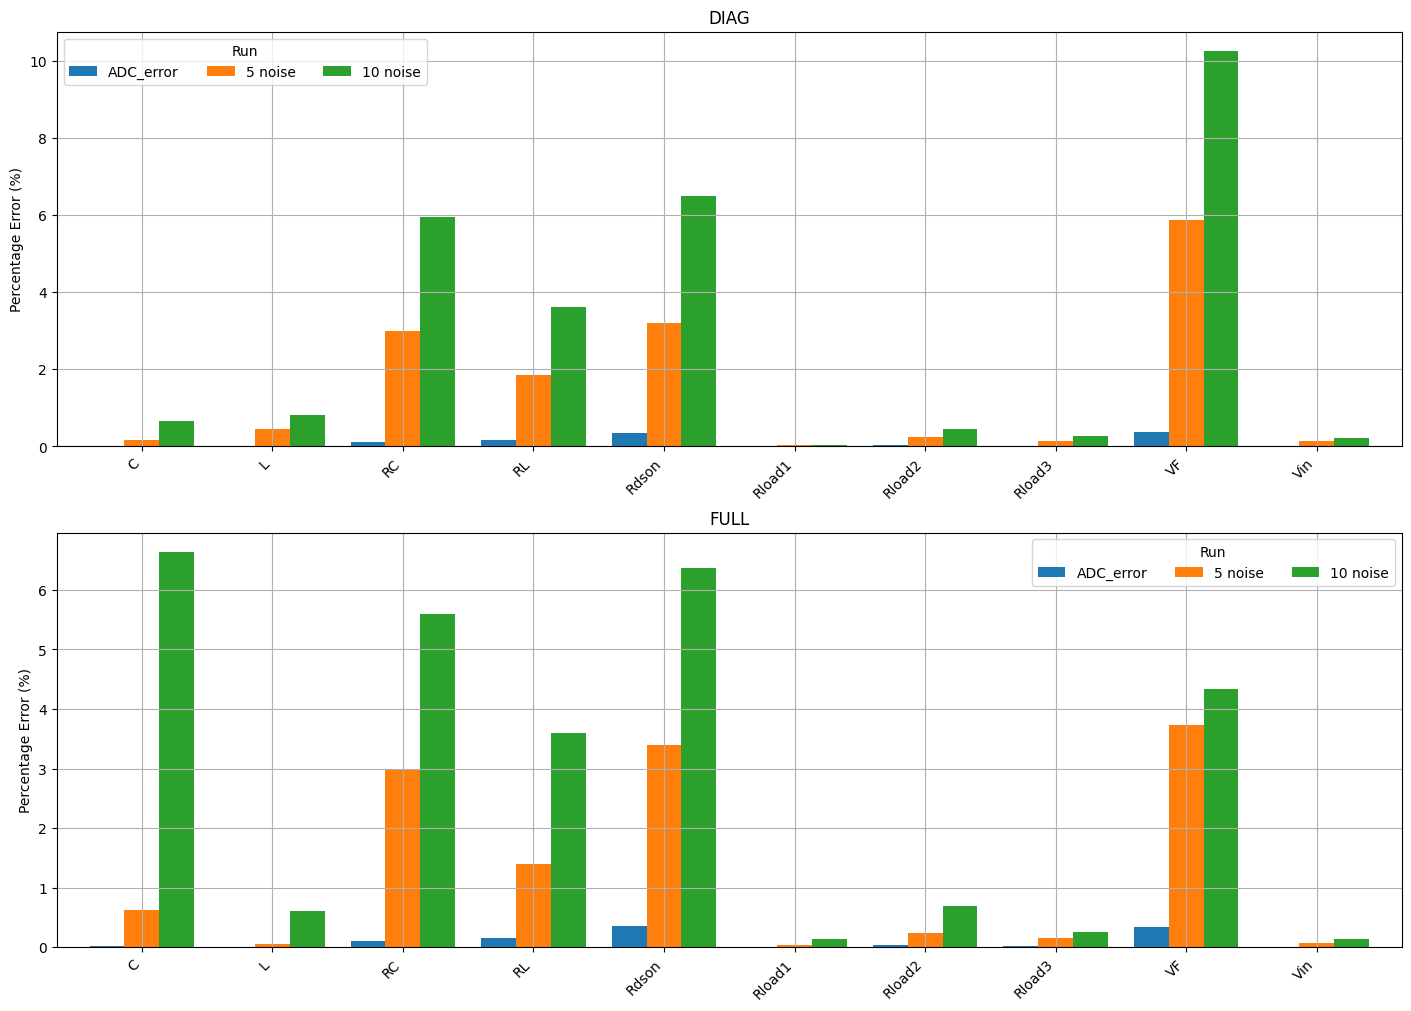

In [ ]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
full_outdir = Path.cwd().parent / "RESULTS" / "Bayesian" / "FullSigma_MAP1"
diag_outdir = Path.cwd().parent / "RESULTS" / "Bayesian" / "DiagSigma_MAP"


csv_files = list(diag_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "DIAG_" + label
    if ii == 1:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_diag = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (1, 3, 4)}


csv_files = list(full_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "FULL_" + label
    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None, linestyle="--")

runs_ordered_full = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (1, 3, 4)}


fig, ax = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_diag, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=True, ax=ax[0]
)
plot_final_percentage_error_multi(
    runs=runs_ordered_full, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=True, ax=ax[1]
)

ax[0].set_title("DIAG")
ax[1].set_title("FULL")

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv


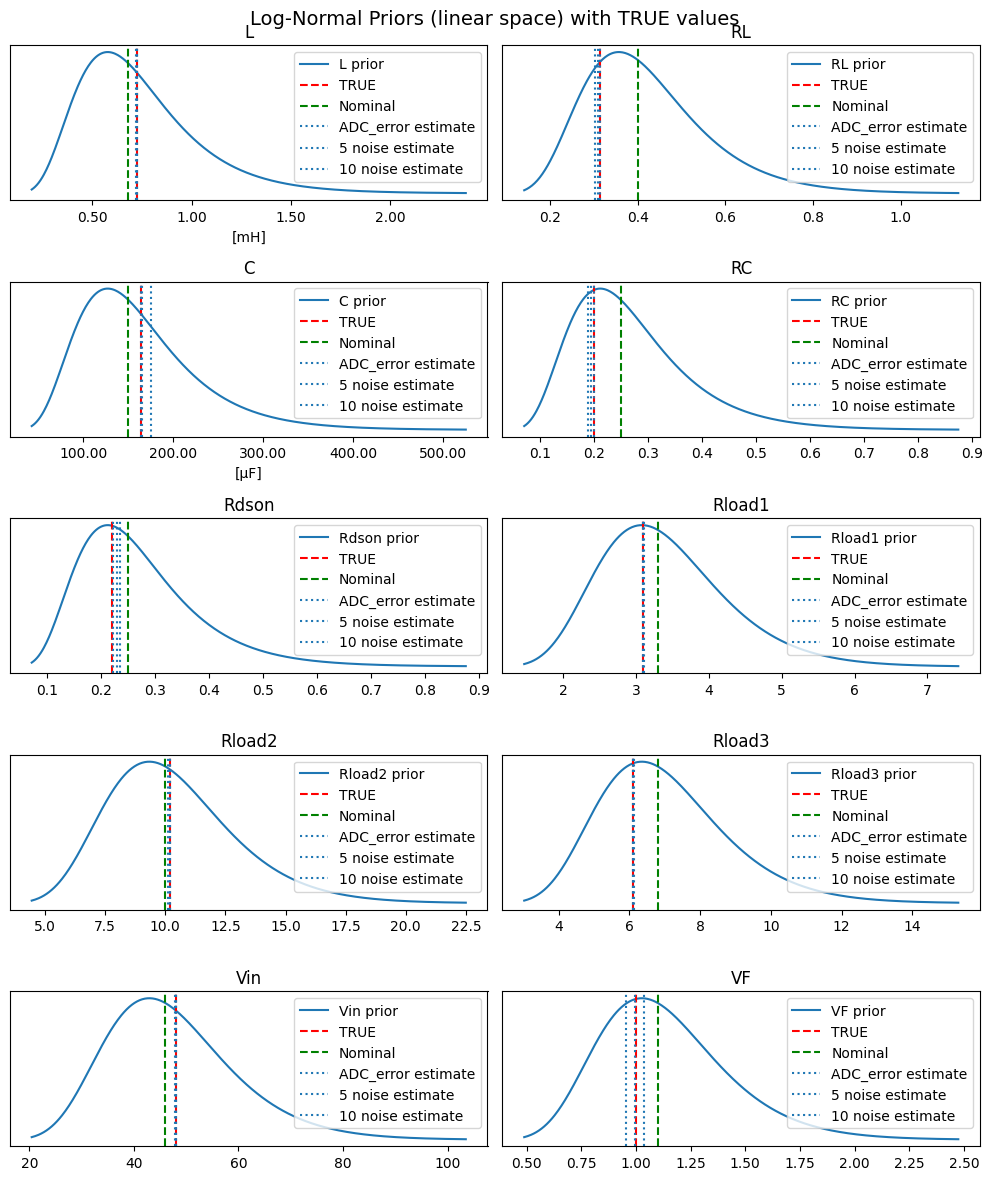

In [ ]:
from typing import Dict
import matplotlib.pyplot as plt

out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "FullSigma_MAP1"
# loop through all CSV files in the directory
csv_files = list(out_dir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}
runs_ordered: Dict[str, TrainingRun] = {
    GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (1, 3, 4)
}

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()


for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)
    estimations_for_different_runs: Dict[str, Parameters] = {
        label: getattr(run.best_parameters, name) for label, run in runs_ordered.items()
    }

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

    # plot the nominal value
    ax.axvline(nominal, color="green", linestyle="--", label="Nominal")

    for label, est in estimations_for_different_runs.items():
        ax.axvline(est, linestyle=":", label=f"{label} estimate")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()

    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("FULL SIGMA MATRIX: Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv


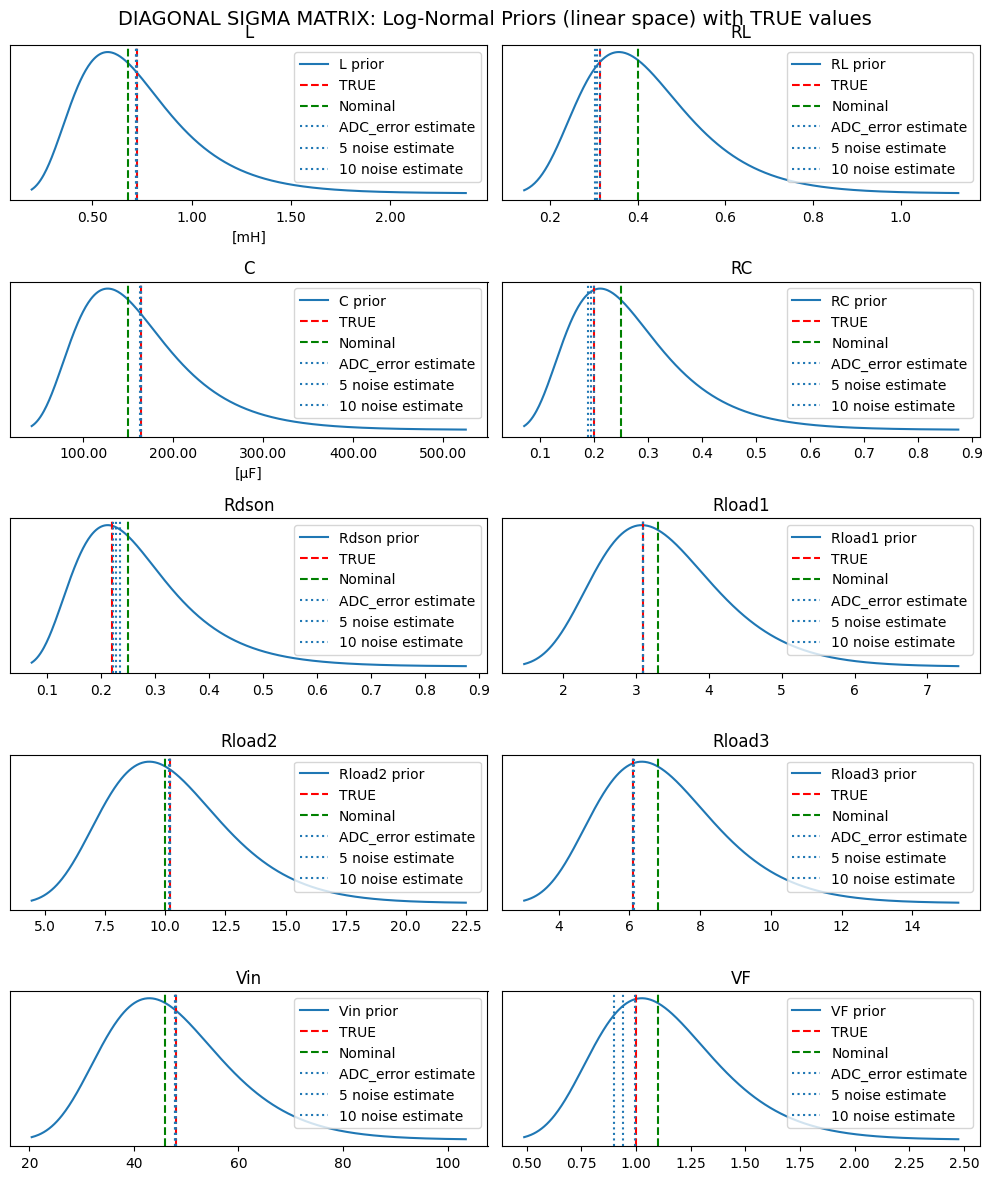

In [ ]:
from typing import Dict
import matplotlib.pyplot as plt

out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "DiagSigma_MAP"
# loop through all CSV files in the directory
csv_files = list(out_dir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}
runs_ordered: Dict[str, TrainingRun] = {
    GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (1, 3, 4)
}

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()


for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)
    estimations_for_different_runs: Dict[str, Parameters] = {
        label: getattr(run.best_parameters, name) for label, run in runs_ordered.items()
    }

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

    # plot the nominal value
    ax.axvline(nominal, color="green", linestyle="--", label="Nominal")

    for label, est in estimations_for_different_runs.items():
        ax.axvline(est, linestyle=":", label=f"{label} estimate")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()

    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("DIAGONAL SIGMA MATRIX: Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Laplace Approximation of the Posterior

In [95]:
from torch.autograd.functional import hessian
from torch.func import functional_call
from scipy.stats import norm, lognorm
import numpy as np
import torch
from torch import nn
from torch.autograd.functional import hessian
from torch.func import functional_call
from dataclasses import dataclass
from typing import Callable, Dict, Any, List

from scipy.stats import norm, lognorm  # --- utilities

# -----------------------------------------------------------------
# user-supplied helpers
#   Parameters, make_log_param, reverse_log_param
#   log_normal_prior, rel_tolerance_to_sigma
#   likelihood_loss_triplets, _parse_data_noise_to_sigma
# must already be imported
# -----------------------------------------------------------------


# -----------------------------------------------------------------#
#   Container for the posterior                                   #
# -----------------------------------------------------------------#
@dataclass
class LaplacePosterior:
    theta_log: torch.Tensor  # MAP in log-space
    Sigma_log: torch.Tensor  # covariance in log-space
    theta_phys: torch.Tensor  # MAP in physical units
    Sigma_phys: torch.Tensor  # covariance in physical units


# -----------------------------------------------------------------#
#   LaplaceFitter class                                            #
# -----------------------------------------------------------------#
class LaplaceFitter:
    """
    Compute a Laplace (Gaussian) approximation to the posterior of a
    BuckParamEstimatorTriplets model.
    """

    # ------------- construction -----------------------------------
    def __init__(
        self,
        model: nn.Module,
        X: torch.Tensor,
        y: torch.Tensor,
        loss_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], torch.Tensor],
        damping: float = 1e-6,
        device: str = "cpu",
    ):
        self.model = model.to(device)
        self.X = X.to(device)
        self.y = y.to(device)
        self.loss_fn = loss_fn
        self.damping = damping
        self.device = device

    # ------------- helper: flatten current log-parameters ---------
    def _flat_logparams(self) -> torch.Tensor:
        """Return  (P,)  vector, requires_grad=True."""
        vec = torch.cat([p.detach().clone().view(1) for p in self.model.logparams]).to(self.device)
        vec.requires_grad_(True)
        return vec

    # ------------- build closure L(θ) ------------------------------
    def _posterior_loss_fn(self) -> Callable[[torch.Tensor], torch.Tensor]:
        """
        Returns f(theta_vec) that:
            1) rewrites model parameters,
            2) runs the triplet forward,
            3) computes −log posterior.
        """
        param_keys = [name for name, _ in self.model.named_parameters()]
        assert len(param_keys) == len(Parameters._fields), "param count mismatch"

        def loss(theta_vec: torch.Tensor) -> torch.Tensor:
            # split flat θ into individual tensors with correct shapes
            split = []
            offset = 0
            for name, p0 in self.model.named_parameters():
                n = p0.numel()
                split.append(theta_vec[offset : offset + n].view_as(p0))
                offset += n

            state_dict = {k: v for k, v in zip(param_keys, split)}  # new θ
            preds = functional_call(self.model, state_dict, (self.X, self.y))
            targets = (
                self.X[:, :2],  # previous time step (i, v)
                self.y,  # current time step (i, v)
            )
            return self.loss_fn(self.model, preds, targets)


        return loss

    # ------------- main entry -------------------------------------
    def fit(self) -> LaplacePosterior:
        theta_map = self._flat_logparams()
        loss_fn = self._posterior_loss_fn()

        # ----- compute MAP gradient once (optional sanity check) ---
        loss_map = loss_fn(theta_map)
        loss_map.backward()

        # ----- Hessian --------------------------------------------
        H = hessian(loss_fn, theta_map)
        H = (H + H.T) * 0.5  # symmetrise

        I = torch.eye(H.shape[0], device=self.device)
        Sigma_log = torch.linalg.inv(H + self.damping * I)

        # ----- convert to physical units ---------------------------
        theta_phys = torch.tensor(
            [getattr(self.model.get_estimates(), n) for n in Parameters._fields],
            device=self.device,
        )
        J = torch.diag(theta_phys)  # ∂θ_phys/∂θ_log = diag(θ_phys)
        Sigma_phys = J @ Sigma_log @ J.T

        return LaplacePosterior(
            theta_log=theta_map.detach(),
            Sigma_log=Sigma_log,
            theta_phys=theta_phys,
            Sigma_phys=Sigma_phys,
        )

    # -------- convenience static helpers --------------------------
    @staticmethod
    def build_gaussian_approx(mean: np.ndarray, cov: np.ndarray):
        std = np.sqrt(np.diag(cov))
        return [norm(loc=m, scale=s) for m, s in zip(mean, std)]

    @staticmethod
    def build_lognormal_approx(mu_log: np.ndarray, sigma_log: np.ndarray):
        return [lognorm(s=s, scale=np.exp(m)) for m, s in zip(mu_log, sigma_log)]

    @staticmethod
    def print_parameter_uncertainty(theta_phys, Sigma_phys):
        std_phys = torch.sqrt(torch.diag(Sigma_phys))
        for i, name in enumerate(Parameters._fields):
            mean = theta_phys[i].item()
            std = std_phys[i].item()
            pct = 100.0 * std / mean
            print(f"{name:8s}: {mean:.3e} ± {std:.1e} ({pct:.2f} %)")

In [ ]:
damp = 1e-5

sigma_adc_full = data_noise_to_sigma(
    data_noise=(noise_power_ADC_i, noise_power_ADC_v),
    jac=J_av,
    calculate_diag_terms=True,
    damp=damp,
)

sigma_5_full = data_noise_to_sigma(
    data_noise=(noise_power_5_i, noise_power_5_v), jac=J_av, calculate_diag_terms=True, damp=damp
)

sigma_10_full = data_noise_to_sigma(
    data_noise=(noise_power_10_i, noise_power_10_v),
    jac=J_av,
    calculate_diag_terms=True,
    damp=damp,
)


print(f"Sigma matrix for ADC noise (full):\n{sigma_adc_full}")
print(f"Sigma matrix for 5 LSB noise (full):\n{sigma_5_full}")
print(f"Sigma matrix for 10 LSB noise (full):\n{sigma_10_full}")

L_inv_adc_full = chol_inv(sigma_adc_full)
L_inv_5_full = chol_inv(sigma_5_full)
L_inv_10_full = chol_inv(sigma_10_full)

noise_power_dict_full = {
    1: L_inv_adc_full,  # ADC error
    3: L_inv_5_full,  # 5 noise
    4: L_inv_10_full,  # 10 noise
}

noise_power_dict = {
    1: L_inv_adc,  # ADC error
    3: L_inv_5,  # 5 noise
    4: L_inv_10,  # 10 noise
}

Sigma matrix for ADC noise (full):
tensor([[ 1.0117e-03, -9.4804e-07, -1.1896e-05,  2.8285e-06],
        [-9.4804e-07,  1.1016e-03, -2.9097e-06, -1.0721e-04],
        [-1.1896e-05, -2.9097e-06,  1.0122e-03,  1.2122e-06],
        [ 2.8285e-06, -1.0721e-04,  1.2122e-06,  1.1135e-03]])
Sigma matrix for 5 LSB noise (full):
tensor([[ 1.2932e-03, -2.3701e-05, -2.9740e-04,  7.0712e-05],
        [-2.3701e-05,  3.5390e-03, -7.2742e-05, -2.6802e-03],
        [-2.9740e-04, -7.2742e-05,  1.3053e-03,  3.0306e-05],
        [ 7.0712e-05, -2.6802e-03,  3.0306e-05,  3.8365e-03]])
Sigma matrix for 10 LSB noise (full):
tensor([[ 2.1729e-03, -9.4804e-05, -1.1896e-03,  2.8285e-04],
        [-9.4804e-05,  1.1156e-02, -2.9097e-04, -1.0721e-02],
        [-1.1896e-03, -2.9097e-04,  2.2213e-03,  1.2122e-04],
        [ 2.8285e-04, -1.0721e-02,  1.2122e-04,  1.2346e-02]])


In [102]:
from pinn_buck.laplace_posterior_fitting import LaplaceApproximator

lfits = {}
io = LoaderH5(db_dir, h5filename)

for number, power in noise_power_dict.items():
    label = GROUP_NUMBER_DICT[number]
    model = trained_models[label]

    lapl_approx = LaplaceApproximator(
        model=model,
        loss_fn=make_map_loss(
            nominal=NOMINAL,
            sigma0=rel_tolerance_to_sigma(REL_TOL),
            L_inv=power,  # use the noise power for the group
        ),
        damping=1e-6,
    )
    io.load(label)
    X, y = io.M.data

    X = torch.tensor(X, device=device)
    y = torch.tensor(y, device=device)

    lfit = lapl_approx.fit(X, y)
    lfits[label] = lfit

    print(f"\nParameter estimates for {label}:")
    lfit.print_param_uncertainty("gaussian")
    print("\n\n")

TypeError: make_map_loss.<locals>._loss() takes 3 positional arguments but 4 were given

In [101]:
lfits = {}

for number, noise_power in noise_power_dict.items():
    label = GROUP_NUMBER_DICT[number]
    model = trained_models[label]
    
    print(f"Loading group {number}: {label}")
    io.load(label)


    # Train the model on the noisy measurement
    X, y, model = load_data_to_model(
        meas=io.M,
        initial_guess_params=NOMINAL,
    )

    # Fit Laplace posterior using the new class
    laplace = LaplaceFitter(
        model=model,
        X=X,
        y=y,
        loss_fn=make_map_loss(
            nominal=NOMINAL,
            sigma0=rel_tolerance_to_sigma(REL_TOL),
            L_inv=noise_power,  # use the full noise power for the group
        ),
        damping=1e-4,
        device="cpu",  # or "cuda" if using GPU
    )
    lfit = laplace.fit()

    # Compute Gaussian and LogNormal approximations
    gaussians = LaplaceFitter.build_gaussian_approx(
        mean=lfit.theta_phys.cpu().numpy(), cov=lfit.Sigma_phys.cpu().numpy()
    )

    lognormals = LaplaceFitter.build_lognormal_approx(
        mu_log=lfit.theta_log.cpu().numpy(),
        sigma_log=np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy()),
    )

    # Print and store
    print(f"\nParameter estimates for {label}:")
    LaplaceFitter.print_parameter_uncertainty(lfit.theta_phys, lfit.Sigma_phys)
    lfits[label] = lfit

Loading group 1: ADC_error

Parameter estimates for ADC_error:
L       : 6.800e-04 ± 5.1e-10 (0.00 %)
RL      : 4.000e-01 ± 2.0e-06 (0.00 %)
C       : 1.500e-04 ± nan (nan %)
RC      : 2.500e-01 ± 3.4e-06 (0.00 %)
Rdson   : 2.500e-01 ± 2.1e-06 (0.00 %)
Rload1  : 3.300e+00 ± nan (nan %)
Rload2  : 1.000e+01 ± 1.2e-04 (0.00 %)
Rload3  : 6.800e+00 ± nan (nan %)
Vin     : 4.600e+01 ± 2.6e-05 (0.00 %)
VF      : 1.100e+00 ± 1.1e-05 (0.00 %)
Loading group 3: 5 noise

Parameter estimates for 5 noise:
L       : 6.800e-04 ± 1.2e-08 (0.00 %)
RL      : 4.000e-01 ± 4.5e-05 (0.01 %)
C       : 1.500e-04 ± nan (nan %)
RC      : 2.500e-01 ± 8.4e-05 (0.03 %)
Rdson   : 2.500e-01 ± 4.9e-05 (0.02 %)
Rload1  : 3.300e+00 ± nan (nan %)
Rload2  : 1.000e+01 ± 3.0e-03 (0.03 %)
Rload3  : 6.800e+00 ± nan (nan %)
Vin     : 4.600e+01 ± 5.9e-04 (0.00 %)
VF      : 1.100e+00 ± 2.5e-04 (0.02 %)
Loading group 4: 10 noise

Parameter estimates for 10 noise:
L       : 6.800e-04 ± 4.7e-08 (0.01 %)
RL      : 4.000e-01 ± 1.8e-0

C:\Users\JC28LS\AppData\Local\Temp\ipykernel_24732\4218778621.py:132: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov))
C:\Users\JC28LS\AppData\Local\Temp\ipykernel_24732\2560245896.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigma_log=np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy()),


In [15]:
tr.df.head()

,loss,L,RL,C,RC,Rdson,Rload1,Rload2,Rload3,Vin,VF
0,343639.281250,0.000730,0.343668,0.000164,0.200779,0.207486,3.100864,10.187969,6.097579,48.240204,1.050441
1,231460.328125,0.000729,0.328547,0.000164,0.200795,0.206507,3.100124,10.195225,6.098625,48.107609,1.057302
2,209900.750000,0.000728,0.320840,0.000165,0.200793,0.214822,3.100026,10.196190,6.098687,48.081928,1.056822
3,204073.937500,0.000727,0.315909,0.000165,0.200791,0.220392,3.099973,10.196712,6.098711,48.065228,1.054561
4,203540.015625,0.000727,0.314188,0.000165,0.200791,0.222218,3.099954,10.196902,6.098722,48.055706,1.049964


## Time-Series Covariance
If we were optimize with the previously derived formula, the results would greatly overestimate the prediction certainties. The reason is that until now we have assumed the residuals $r^\text{obs} \sim \mathcal{N}(r, \Sigma_r)$, so that the likelihood from the data can be calculated as: 
$$ \log 
\left[ 
\prod_{i=1}^N p_i(r_i | x_i, z)
\right] = ...  = \frac{1}{2}
      \sum_{i=0}^{N-1}\! r_i \Sigma_r^{-1} r_i^\top
$$

However, we cannot say that the residuals are i.i.d. Indeed, the successive values of our **state vector**

$$
x_n = (i_n, v_n)^\top
$$

are **not independent and identically distributed (i.i.d.)**, but they evolve along a smooth trajectory, meaning $x_{n+1}$ is **highly correlated** with $x_n$.

If we define the usual “level–residual”

$$
r_n = y_{n}^{\text{pred}} - y_{n}^{\text{obs}},
$$

and minimize its squared norm under a Gaussian likelihood, the optimizer implicitly treats each $r_n$ as **an independent data point**.
This **overcounts** information, leading to artificially **narrow posteriors** and **underestimated uncertainties**.

---

### First-Differencing: A Classical Solution

A well-known technique to reduce autocorrelation in time series is **first-differencing**:

$$
\Delta x_n = x_{n+1} - x_n.
$$

This is often used to make nonstationary or correlated series more like white noise (Box–Jenkins methodology, ARIMA modeling, etc.).
We adopt the same idea at the residual level.

### Increment (Δ) Residual

The model performs step-wise prediction:

$$
y_{n+1}^{\text{pred}} = f_z(x_n).
$$

So the natural quantity of interest is not just how accurate $y_{n+1}^{\text{pred}}$ is,
but how well the model captures the **change** in state.

Let us define:

* The **predicted increment**:

  $$
  \Delta y^{\text{pred}} = y_{n+1}^{\text{pred}} - y_n^{\text{pred}},
  $$
* The **observed increment**:

  $$
  \Delta y^{\text{obs}} = y_{n+1}^{\text{obs}} - y_n^{\text{obs}}.
  $$

Then we define the **increment residual** as

$$
\boxed{
r_\Delta = \Delta y^{\text{pred}} - \Delta y^{\text{obs}}
         = (y_{n+1}^{\text{pred}} - y_n^{\text{pred}})
         - (y_{n+1}^{\text{obs}} - y_n^{\text{obs}})
}
$$

In terms of level-residuals,

$$
r_n = y_{n+1}^{\text{pred}} - y_{n+1}^{\text{obs}}, \quad
r_{n-1} = y_n^{\text{pred}} - y_n^{\text{obs}},
$$

we get

$$
r_\Delta = r_n - r_{n-1}.
$$

---

### Why the Δ–Residual Is Better

* **De-correlation**:
  Subtracting successive residuals eliminates the smooth, shared component of $r_n$ and $r_{n-1}$.
  What remains is mostly sensor noise and model error, which are far more independent.
  This matches the assumptions of the Gaussian likelihood far more closely.

* **Effective Sample Size**:
  Because residuals become closer to uncorrelated, the model no longer overestimates information from nearly-duplicate points.
  As a result, the **Hessian becomes smaller**, the **Laplace approximation becomes broader**, and uncertainty estimates become more realistic.


## Model Considerations and Simplifications

To compute $r_\Delta$, we need both
$y_{n+1}^{\text{pred}}$ and $y_n^{\text{pred}}$.
The previous version of the model uses **backward RK4** to infer $y_n^{\text{pred}}$ from $y_{n+1}^{\text{obs}}$. Although it seems that this is perfect for what we need, actually it is problematic.

Indeed:

$$
y_n^{\text{pred}} = f_z^{-1}(y_{n+1}^{\text{obs}})
$$

uses **noisy future data**, so

$$
\text{noise}(y_n^{\text{pred}}) \sim J^{-1} \varepsilon_{n+1},
$$

which is **correlated** with $y_{n+1}^{\text{pred}}$. Thus we would need to derive a more complex $\Sigma_{\Delta}$, accounting for backward propagation of noise.

Instead, if we try to avoid this issue by using the **true observation** at time $n$ rather than a backward model step:

$$
r_\Delta = (y_{n+1}^{\text{pred}} - y_n^{\text{obs}}) - (y_{n+1}^{\text{obs}} - y_n^{\text{obs}})
= y_{n+1}^{\text{pred}} - y_{n+1}^{\text{obs}}.
$$

we end up with the old residual. 

Therefore, we need to update the model to:  

1. Use **only forward prediction**
2. Consider **two steps at a time**

## 3 Assemble the increment residual

Substitute the linearised forms and observed values:

$$
\begin{aligned}
r^\text{obs}_\Delta
  &\;=\;
     (y_{n+1}^{\text{pred}}\!-\!y_{n }^{\text{pred}})
     \;-\;
     (y_{n+1}^{\text{obs}}\!-\!y_{n }^{\text{obs}}) \\[4pt]
  &\approx
     \bigl(y_{n+1}-y_n\bigr)
     + \bigl(J_n\,\varepsilon_n - J_{n-1}\,\varepsilon_{n-1}\bigr) \\[-2pt]
  &\quad
     -\bigl(y_{n+1}-y_n\bigr)
     - \bigl(\varepsilon_{n+1}-\varepsilon_{n}\bigr) \\[6pt]
  &= r_\Delta + (J_n + I)\,\varepsilon_n \;-\; J_{n-1}\,\varepsilon_{n-1} \;-\; \varepsilon_{n+1}.
\end{aligned}
$$

All three noise terms
$\varepsilon_{n-1},\varepsilon_n,\varepsilon_{n+1}$
are **independent** and have covariance $\Sigma_x$.

Therefore the variance of $r_\Delta$ is:
$$
\operatorname{Var}[r_\Delta]
   = (J_n + I)\,\Sigma_x\,(J_n + I)^{\!\top}
     \;+\;
     J_{n-1}\,\Sigma_x\,J_{\,n-1}^{\!\top}
     \;+\;
     \Sigma_x.
$$


And assuming we have  a **slowly-varying Jacobian** (constant J)
   If $J_{n-1}\approx J_n \approx J$,

   $$
   \boxed{
   \operatorname{Var}[r_\Delta]
     \approx (J+I)\Sigma_x(J+I)^{\!\top} + J\Sigma_x J^{\!\top} + \Sigma_x.
   }
   $$



## 5 Interpretation

* The first term $(J_n + I)\Sigma_x(J_n + I)^\top$ is the propagated
  noise from the current measurement $\varepsilon_n$.
* The second term $J_{n-1}\Sigma_xJ_{n-1}^\top$ is propagated noise from the
  **previous** measurement $\varepsilon_{n-1}$.
* The last term $\Sigma_x$ is the direct sensor noise at $n+1$.
---

This derivation shows precisely how the minus sign and the independence of sensor noise translate into the residual covariance needed for a sound Gaussian likelihood on first-differences.



## Covariance Between Residuals

To compute the loss based on the **first-difference residual**

$$
r_{\Delta,n} = \Delta y^{\text{pred}} - \Delta y^{\text{obs}},
$$

we require two predicted values: $y_{n+1}^{\text{pred}}$ and $y_n^{\text{pred}}$.

We consider different implementation strategies and evaluate how they affect the correlation between residuals, which in turn affects the **validity of assuming independence in the likelihood**.

---

### 1. **Using a Cached Previous Prediction**

In this setup, residuals are computed consecutively:

$$
r_{\Delta,n} = (J_n + I)\varepsilon_n - J_{n-1}\varepsilon_{n-1} - \varepsilon_{n+1}
$$

$$
r_{\Delta,n+1} = (J_{n+1} + I)\varepsilon_{n+1} - J_n \varepsilon_n - \varepsilon_{n+2}
$$

Compute the covariance:

$$
\begin{aligned}
\operatorname{Cov}(r_{\Delta,n}, r_{\Delta,n+1})
&= \mathbb{E}[r_{\Delta,n} r_{\Delta,n+1}^\top] \\
&= \underbrace{\mathbb{E}[(J_n + I)\varepsilon_n \cdot (-J_n \varepsilon_n)^\top]}_{-(J_n + I)\Sigma_x J_n^\top}
+ \underbrace{\mathbb{E}[-\varepsilon_{n+1} \cdot (J_{n+1} + I)\varepsilon_{n+1}^\top]}_{-\Sigma_x (J_{n+1} + I)^\top}
\end{aligned}
$$

Hence:

$$
\boxed{
\operatorname{Cov}(r_{\Delta,n}, r_{\Delta,n+1}) =
-(J_n + I)\Sigma_x J_n^\top - \Sigma_x (J_{n+1} + I)^\top
}
$$

**Conclusion:** this strategy **induces residual correlation**, violating independence assumptions. The overlap between $r_{\Delta,n}$ and $r_{\Delta,n+1}$ (due to shared predictions) causes this.

---

### 2. **Partitioning Data into Disjoint Pairs**

We define residuals over non-overlapping windows, e.g., predictions on $(n, n+1)$ and predictions on $(n+2, n+3)$:

$$
r_{\Delta,n} = (J + I)\varepsilon_n - J\varepsilon_{n-1} - \varepsilon_{n+1}
$$

$$
r_{\Delta,n+2} = (J + I)\varepsilon_{n+2} - J \varepsilon_{n+1} - \varepsilon_{n+3}
$$

Here, both residuals share **only one common noise term**, $\varepsilon_{n+1}$, which appears as:

* $-\varepsilon_{n+1}$ in $r_{\Delta,n}$
* $-J \varepsilon_{n+1}$ in $r_{\Delta,n+2}$

So:

$$
\operatorname{Cov}(r_{\Delta,n}, r_{\Delta,n+2}) = \mathbb{E}[-\varepsilon_{n+1} \cdot (-J \varepsilon_{n+1})^\top] = J \Sigma_x
$$

$$
\boxed{
\operatorname{Cov}(r_{\Delta,n}, r_{\Delta,n+2}) = J \Sigma_x
}
$$

This is **non-zero**, so residuals still exhibit dependence — though they are more weakly correlated than in the cached case.

---

### 3. **Partitioning into Independent Triplets**

Suppose we form non-overlapping triplets, e.g., $(x_0,x_1,x_2), (x_3,x_4,x_5),\dots$

In this case, **each residual $r_{\Delta,k}$** depends only on:

$$
\varepsilon_{3k-1},\quad \varepsilon_{3k},\quad \varepsilon_{3k+1}
$$

and

$$
r_{\Delta,k+1} \text{ depends on } \varepsilon_{3k+2},\quad \varepsilon_{3k+3},\quad \varepsilon_{3k+4}
$$

So all noise terms are **disjoint** between residuals. Therefore:

$$
\boxed{
\operatorname{Cov}(r_{\Delta,k}, r_{\Delta,k+1}) = 0
}
$$

Residuals are **truly uncorrelated**, so the **likelihood decomposition into i.i.d. terms is valid**.

---

## In summary

| Strategy                      | Residual Independence  | Data Utilization |
| ----------------------------- | --------------------- | ---------------- |
| **Cache previous prediction** | ❌ High correlation   | ✅ Full data      |
| **Disjoint pairs**            | ⚠️ Some correlation   | ⚠️ 50% data      |
| **Independent triplets**      | ✅ Fully independent  | ⚠️ 33% data      |

For mathematical rigor we start by implementing the model that uses independent triplets. Then we can make some compromises to utilise the available data more fully. 


## Check Forward vs Forward & Backward

In [7]:
from typing import Callable, Union, Iterable
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from contextlib import contextmanager
import math

# let's define a function to convert relative tolerances to standard deviations
# using the log-normal distribution assumption.
# Previously, we assumed sigma = log(1 + rel_tol). This means we assume that the relative toleraces contain 1 standard deviation
# of the data. Although usually the relative tolerances are defined as 2 or 3 standard deviations, we will use 1 standard deviation
# since this is the worst case scenario.

def rel_tolerance_to_sigma(rel_tol: Parameters) -> Parameters:
    """Convert relative tolerances to standard deviations."""

    def _to_sigma(value: float) -> torch.Tensor:
        """Convert a relative tolerance to standard deviation."""
        return torch.log(torch.tensor(1 + value, dtype=torch.float32))

    return Parameters(
        L=_to_sigma(rel_tol.L),
        RL=_to_sigma(rel_tol.RL),
        C=_to_sigma(rel_tol.C),
        RC=_to_sigma(rel_tol.RC),
        Rdson=_to_sigma(rel_tol.Rdson),
        Rload1=_to_sigma(rel_tol.Rload1),
        Rload2=_to_sigma(rel_tol.Rload2),
        Rload3=_to_sigma(rel_tol.Rload3),
        Vin=_to_sigma(rel_tol.Vin),
        VF=_to_sigma(rel_tol.VF),
    )

# define the log-normal prior for the parameters assuming independent priors distrubuted according to the log-normal distribution.
# See the formula above.
def log_normal_prior(logparams: Parameters, nominal: Parameters, sigma: Parameters) -> torch.Tensor:
    """Return −log p(log z) assuming independent log-normal priors."""
    total = 0.0
    nominal_logparams = make_log_param(nominal)
    for name in Parameters._fields:
        proposed_value = getattr(logparams, name)
        mu = getattr(nominal_logparams, name)
        sig = getattr(sigma, name)
        total += ((proposed_value - mu) / sig) ** 2 / 2
    return total


def _parse_data_noise_to_sigma(data_noise: Union[float, Iterable, torch.Tensor]) -> torch.Tensor:
    """Parse data_noise and return the inverse covariance matrix Sigma_x_inv."""
    if isinstance(data_noise, float):
        a = data_noise
        b = data_noise
        return torch.diag(torch.tensor([a, b], dtype=torch.float32))
    elif isinstance(data_noise, torch.Tensor):
        if data_noise.shape != (2, 2):
            raise ValueError("If data_noise is a tensor, it must be 2x2.")
        return data_noise
    elif isinstance(data_noise, Iterable):
        data_noise = list(data_noise)
        if len(data_noise) != 2:
            raise ValueError("If data_noise is iterable, it must be of length 2.")
        a = data_noise[0]
        b = data_noise[1]
        return torch.diag(torch.tensor([a, b], dtype=torch.float32))
    else:
        raise TypeError("data_noise must be float, 2-tensor, or iterable of length 2.")


def likelihood_loss(preds, y_n, y_np1, Sigma: torch.Tensor) -> torch.Tensor:
    """
    Compute −log likelihood with Mahalanobis norm using per-variable covariance.
    preds: tuple of (i_n, v_n, i_np1, v_np1)
    y_n, y_np1: true values at time steps n and n+1
    Sigma_x_inv: 2x2 inverse covariance matrix for [i, v]
    """
    i_n, v_n, i_np1, v_np1 = preds
    i0, v0 = y_n[:, 0:1], y_n[:, 1:2]
    i1, v1 = y_np1[:, 0:1], y_np1[:, 1:2]

    # Residuals: shape [N, 2]
    res_0 = torch.cat([i_n - i0, v_n - v0], dim=1)
    res_1 = torch.cat([i_np1 - i1, v_np1 - v1], dim=1)

    # Stack both sets of residuals: shape [2N, 2]
    residuals = torch.cat([res_0, res_1], dim=0)

    # Cholensky approach
    L = torch.linalg.cholesky(Sigma)                    # (2,2), lower-tri
    z = torch.linalg.solve_triangular(L, residuals.T, upper=False).T
    return 0.5 * z.pow(2).sum()


def likelihood_loss_triplets(
    preds: torch.Tensor, targets: torch.Tensor, Sigma: torch.Tensor  # (N,4)  # (N,4)  # (2,2)
) -> torch.Tensor:
    """
    Negative log-likelihood for Δ-residuals under
    r_Δ ∼ 𝒩(0, Σ),    Σ = Sigma (2×2).
    """
    # --- split columns ------------------------------------------------
    i_np1_pred, v_np1_pred, i_n_pred, v_n_pred = preds.T  # (N,)
    i_np1_true, v_np1_true, i_n_true, v_n_true = targets.T  # (N,)

    # --- build increments --------------------------------------------
    delta_pred = torch.stack([i_np1_pred - i_n_pred, v_np1_pred - v_n_pred], dim=1)  # (N,2)
    delta_obs = torch.stack([i_np1_true - i_n_true, v_np1_true - v_n_true], dim=1)  # (N,2)

    residuals = delta_pred - delta_obs  # (N,2)

    # --- Mahalanobis term via whitening ------------------------------
    L = torch.linalg.cholesky(Sigma)  # (2,2)
    z = torch.linalg.solve_triangular(L, residuals.T, upper=False).T  # (N,2)
    nll = 0.5 * z.pow(2).sum()  # scalar
    return nll


# define the loss function for MAP estimation that combines the L2 loss and the log-normal prior.
def make_map_loss(
    nominal: Parameters, sigma: Parameters, residual_covariance: Union[float, Iterable, torch.Tensor] = 1.0
) -> Callable:

    residual_covariance = _parse_data_noise_to_sigma(residual_covariance)
    def _loss(model, preds, targets):
        ll = likelihood_loss_triplets(preds, targets, residual_covariance)
        prior = log_normal_prior(model.logparams, nominal, sigma) 
        return ll + prior

    return _loss

In [22]:
from dataclasses import dataclass

# for simplicity let's define a dataclass for the training configurations
@dataclass
class AdamOptTrainingConfigs:
    savename: str = "saved_run"
    out_dir: Path = Path(".")
    lr: float = 1e-3
    epochs: int = 30_000
    epochs_lbfgs: int = 1500
    device: str = "cpu"
    patience: int = 5000
    lr_reduction_factor: float = 0.5

from typing import Callable, Dict, List, Any
from functools import partial


class TrainerTriplets:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        optim_cfg: "AdamOptTrainingConfigs",
        device: str = "cpu",
    ):
        self.model = model.to(device)
        # expects (preds, targets)
        self.optim_cfg = optim_cfg
        self.device = device
        self.loss_fn = loss_fn
        # history for plotting / CSV export
        self.history: Dict[str, List[Any]] = {"loss": [], "params": [], "lr": []}

    # -----------------------------------------------------------------
    def _record(self, loss_val: float):
        est = self.model.get_estimates()
        self.history["loss"].append(loss_val)
        self.history["params"].append(est)
        # LR from the first param-group (Adam & LBFGS both expose it)
        self.history["lr"].append(self.opt.param_groups[0]["lr"])

    # -----------------------------------------------------------------
    def fit(self, X: torch.Tensor, epochs_adam: int = 20_000, epochs_lbfgs: int = 500):

        X = X.to(self.device)

        # ------------- Adam phase ------------------------------------
        self.opt = torch.optim.Adam(self.model.parameters(), lr=self.optim_cfg.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt,
            mode="min",
            factor=self.optim_cfg.lr_reduction_factor,
            patience=self.optim_cfg.patience,
        )

        best_loss = float("inf")

        for it in range(epochs_adam):
            self.opt.zero_grad()
            preds, targets = self.model(X)  # <- new API
            loss = self.loss_fn(self.model, preds, targets)
            loss.backward()
            self.opt.step()
            scheduler.step(loss.item())

            if (it % 1000) == 0:
                self._record(loss.item())
                best_loss = min(best_loss, loss.item())

                est = self.model.get_estimates()
                grad_norm = (
                    torch.cat(
                        [p.grad.view(-1) for p in self.model.parameters() if p.grad is not None]
                    )
                    .norm()
                    .item()
                )

                print(
                    f"[Adam {it:>6}] "
                    f"loss={loss.item():.3e}, grad‖={grad_norm:.3e}, "
                    f"L={est.L:.2e}, C={est.C:.2e}, "
                    f"Rload1={est.Rload1:.2e}, Rload2={est.Rload2:.2e}, "
                    f"Rload3={est.Rload3:.2e}"
                )

        print("Adam finished.  Best loss:", best_loss)

        # ------------- LBFGS phase -----------------------------------
        print("Starting LBFGS optimisation …")
        self.opt = torch.optim.LBFGS(
            self.model.parameters(),
            max_iter=epochs_lbfgs,
            line_search_fn="strong_wolfe",
            tolerance_grad=1e-8,
        )

        def closure():
            self.opt.zero_grad()
            preds, targets = self.model(X)
            loss = self.loss_fn(self.model, preds, targets)
            loss.backward()
            return loss

        self.opt.step(closure)
        final_loss = closure().item()
        self._record(final_loss)
        print("LBFGS finished.  Final loss:", final_loss)
        # print the final parameter estimations
        print("Final parameter estimates:")
        est = self.model.get_estimates()
        print(
            f"L={est.L:.2e}, C={est.C:.2e}, "
            f"Rload1={est.Rload1:.2e}, Rload2={est.Rload2:.2e}, "
            f"Rload3={est.Rload3:.2e},"
        )

        # ------------- save history ----------------------------------
        run = TrainingRun.from_histories(
            loss_history=self.history["loss"],
            param_history=self.history["params"],
        )
        out_dir = self.optim_cfg.out_dir
        out_dir.mkdir(parents=True, exist_ok=True)
        csv_name = (
            self.optim_cfg.savename
            if str(self.optim_cfg.savename).endswith(".csv")
            else f"{self.optim_cfg.savename}.csv"
        )
        run.save_to_csv(out_dir / csv_name)

        return self.model

In [23]:
# get data noise values

# ADC noise is 1 LSB, so we can assume that the data noise is 1 LSB
# 5 noise is 5 LSB, 10 noise is 10 LSB

# A least significant bit (LSB) is the smallest unit of data in a digital system and is calculated as:
#         LSB_i = I_FS / (2**12 - 1)  # assuming 12-bit ADC
#         LSB_v = V_FS / (2**12 - 1)  # assuming 12-bit ADC

# where I_FS is the full-scale current, set to 10 A and V_FS is the full-scale voltage set to 30 V (see 03_inspect_noisy_data.ipynb).

# Then the noise level is calculated as:
#         noise_level_i = noise_level * LSB_i  # normalize noise level to LSB
#         noise_level_v = noise_level * LSB_v  # normalize noise level to LSB

lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2

Now let's estimate the Frobenius norm by using the autograd function included in pytorch. 

The best solution would be to **pretrain the model to be close to the correct physical quantities of the parameters**. But for simplicity we can use the nominal values. 

Moreover, the noise on i and the noise on v may be very different in magnitude. However, again for simplicity we calculate a single Frobenius norm for both. 

In [24]:
from torch.autograd.functional import jacobian

# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model


def estimate_avg_Jacobian(model, X, y, max_samples=10)-> torch.Tensor:
    model.eval()
    X = X.detach()
    y = y.detach()

    jacobians = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        # Define function of ONLY the noisy inputs: i, v
        def f_noisy_inputs(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            i_pred, v_pred = model(x_full, y_input)[2:]
            return torch.cat([i_pred, v_pred], dim=1).squeeze()  # shape (2,)

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        J = jacobian(f_noisy_inputs, i_v_input)  # shape (2, 2)
        jacobians.append(J)
    return torch.stack(jacobians).mean(0)  # average over all jacobians


jacobians = {}
# Loop through all groups and estimate the Frobenius norm for each group

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model = load_data_to_model(io.M, initial_guess_params=NOMINAL)

    print(f"Estimating Jacobian for group {group_name}...")
    jac = estimate_avg_Jacobian(model, X_t, y_t, max_samples=300)
    jacobians[group_name] = jac
    print(f"Jacobain for group {group_name} ({jac.shape}): {jac}")

# average the Frobenius norms across all groups
J_av = torch.stack(list(jacobians.values())).mean(0)
print(f"Average Frobenius norm across all groups: {jacobian}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Jacobain for group 10 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Average Frobenius norm across all groups: <function jacobian at 0x000002067FE93E20>


In [25]:
# what is the error in the Frobenius norm estimation, with respect to the true parameter values?
for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model_tr = load_data_to_model(io.M, initial_guess_params=TRUE_PARAMS)

    print(f"Estimating Jacobian for group {group_name}...")
    jac = estimate_avg_Jacobian(model_tr, X_t, y_t, max_samples=300)
    jacobians[group_name] = jac
    print(f"Jacobain for group {group_name} ({jac.shape}): {jac}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Jacobain for group 10 noise (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])


In [26]:
def estimate_avg_frobenius_norm(model, X, y, max_samples=10):
    model.eval()
    X = X.detach()
    y = y.detach()

    norms_squared = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        # Define function of ONLY the noisy inputs: i, v
        def f_noisy_inputs(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            i_pred, v_pred = model(x_full, y_input)[2:]
            return torch.cat([i_pred, v_pred], dim=1).squeeze()  # shape (2,)

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        J = jacobian(f_noisy_inputs, i_v_input)  # shape (2, 2)
        frob_norm_sq = torch.norm(J, p="fro") ** 2
        norms_squared.append(frob_norm_sq.item())

    return sum(norms_squared) / len(norms_squared)


# compare with the Frobenius norm used previously
frob_sq_direct = torch.norm(J_av, p="fro").pow(2)
frob_sq_avg = estimate_avg_frobenius_norm(model, X_t, y_t, max_samples=300)

print(f"Frobenius norm squared (direct): {frob_sq_direct:.3e}")
print(f"Frobenius norm squared (average): {frob_sq_avg:.3e}")

Frobenius norm squared (direct): 1.868e+00
Frobenius norm squared (average): 1.868e+00


We can see that the values of the Frobenius norm with the true parameters are quite close to the one obtained with the nominal parameters!

Now we can rescale the noise powers using the formula:

   $$
   \boxed{
   \operatorname{Var}[r_\Delta]
     \approx (J+I)\Sigma_x(J+I)^{\!\top} + J\Sigma_x J^{\!\top} + \Sigma_x.
   }
   $$

In [27]:
# rescale the noise powers
Sigma_x_ADC = torch.tensor([[noise_power_ADC_i, 0], [0, noise_power_ADC_v]], dtype=torch.float32)
Sigma_x_5 = torch.tensor([[noise_power_5_i, 0], [0, noise_power_5_v]], dtype=torch.float32)
Sigma_x_10 = torch.tensor([[noise_power_10_i, 0], [0, noise_power_10_v]], dtype=torch.float32)

# transform noise power to the covariance matrix of the residuals
def transform_noise_to_residual_covariance(noise_power: torch.Tensor, J: torch.Tensor) -> torch.Tensor:
    """Transform noise power to the covariance matrix of the residuals."""
    # J is the Jacobian, noise_power is a 2x2 diagonal matrix
    return (J + torch.eye(2)) @ noise_power @ (J + torch.eye(2)).T + J @ noise_power @ J.T + noise_power

# Propagate the noise through the Jacobian to get the rescaled noise power
Sigma_tot_ADC = transform_noise_to_residual_covariance(Sigma_x_ADC, J_av)
Sigma_tot_5 = transform_noise_to_residual_covariance(Sigma_x_5, J_av)
Sigma_tot_10 = transform_noise_to_residual_covariance(Sigma_x_10, J_av)

print(f"Sigma_tot_ADC:\n{Sigma_tot_ADC}")
print(f"Sigma_tot_5:\n{Sigma_tot_5}")
print(f"Sigma_tot_10:\n{Sigma_tot_10}")


Sigma_tot_ADC:
tensor([[ 3.5116e-05, -2.9286e-06],
        [-2.9286e-06,  3.0437e-04]])
Sigma_tot_5:
tensor([[ 8.7791e-04, -7.3214e-05],
        [-7.3214e-05,  7.6094e-03]])
Sigma_tot_10:
tensor([[ 0.0035, -0.0003],
        [-0.0003,  0.0304]])


In [30]:
from pinn_buck.model.model_param_estimator import BuckParamEstimatorTriplets

out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "Adam_MAP"

run_configs = AdamOptTrainingConfigs(
    savename="adam_run.csv",
    out_dir=out_dir,
    lr=lr,
    epochs=30000,  # 30k epochs for Adam
    epochs_lbfgs=10000,
    device=device,
    patience=patience,
    lr_reduction_factor=lr_reduction_factor,
)


# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimatorTriplets(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model

noise_power_dict = {
    0: 1e-9,  # ideal
    1: Sigma_tot_ADC,  # ADC error
    3: Sigma_tot_5,  # 5 noise
    4: Sigma_tot_10,  # 10 noise
}


noisy_measurements = {}
trained_models = {}
inverse = False

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    run_configs.savename = f"noisy_run_{group_name}.csv"

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X, y, model = load_data_to_model(
        meas=io.M,
        initial_guess_params=NOMINAL,
    )

    prior_info = {
        "nominal": NOMINAL,
        "sigma": rel_tolerance_to_sigma(REL_TOL),
    }


    trainer = TrainerTriplets(
        model=model,
        loss_fn=make_map_loss(
            **prior_info,
            residual_covariance=noise_power_dict[group_number],  # use the noise power for the group
        ),
        optim_cfg=run_configs,
        device=device,
    )

    trainer.fit(
        X=X,
        epochs_adam=run_configs.epochs,
        epochs_lbfgs=run_configs.epochs_lbfgs,
    )
    inverse = True  # inverse is False only for the ideal case, so we set it to True for the rest of the groups
    trained_models[group_name] = trainer.model
    print("\n \n \n")

Loading group 0: ideal

--------------------------------------------------
0) Training with ideal data
[Adam      0] loss=1.034e+09, grad‖=2.909e+10, L=6.81e-04, C=1.50e-04, Rload1=3.30e+00, Rload2=9.99e+00, Rload3=6.79e+00
[Adam   1000] loss=1.783e+05, grad‖=7.086e+06, L=7.02e-04, C=1.54e-04, Rload1=3.01e+00, Rload2=7.98e+00, Rload3=5.50e+00
[Adam   2000] loss=1.427e+05, grad‖=2.198e+06, L=7.03e-04, C=1.57e-04, Rload1=3.01e+00, Rload2=8.06e+00, Rload3=5.52e+00
[Adam   3000] loss=1.200e+05, grad‖=1.952e+06, L=7.04e-04, C=1.57e-04, Rload1=3.02e+00, Rload2=8.21e+00, Rload3=5.57e+00
[Adam   4000] loss=9.052e+04, grad‖=1.641e+06, L=7.04e-04, C=1.58e-04, Rload1=3.03e+00, Rload2=8.44e+00, Rload3=5.64e+00
[Adam   5000] loss=5.847e+04, grad‖=1.247e+06, L=7.06e-04, C=1.59e-04, Rload1=3.04e+00, Rload2=8.76e+00, Rload3=5.73e+00
[Adam   6000] loss=3.044e+04, grad‖=9.253e+05, L=7.08e-04, C=1.61e-04, Rload1=3.06e+00, Rload2=9.17e+00, Rload3=5.85e+00
[Adam   7000] loss=1.213e+04, grad‖=9.485e+05, L=7

Processing adam_run.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


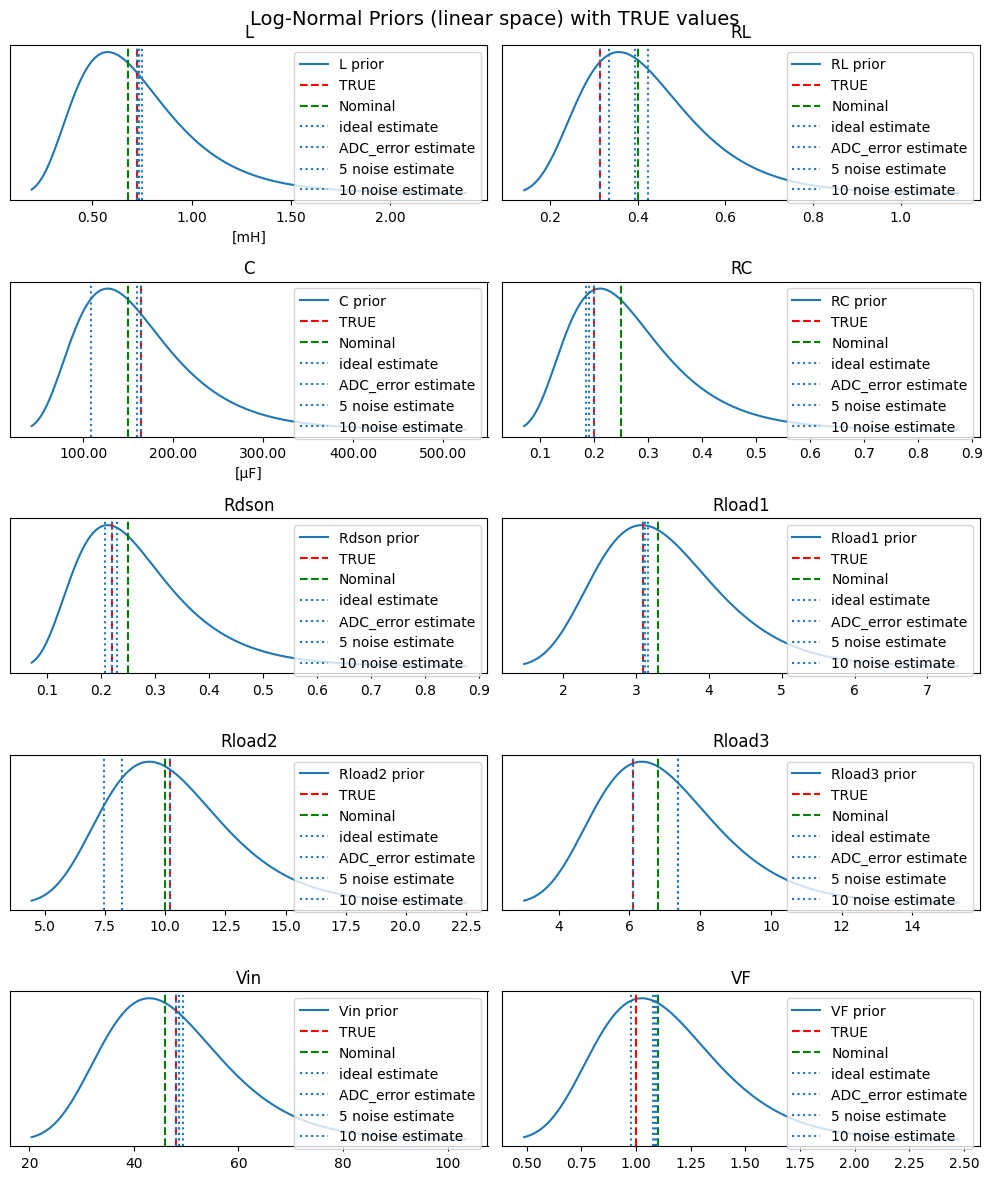

In [31]:
from typing import Dict
import matplotlib.pyplot as plt


# loop through all CSV files in the directory
csv_files = list(out_dir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}
runs_ordered: Dict[str, TrainingRun] = {
    GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)
}

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()


for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)
    estimations_for_different_runs: Dict[str, Parameters] = {
        label: getattr(run.best_parameters, name) for label, run in runs_ordered.items()
    }

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

    # plot the nominal value
    ax.axvline(nominal, color="green", linestyle="--", label="Nominal")

    for label, est in estimations_for_different_runs.items():
        ax.axvline(est, linestyle=":", label=f"{label} estimate")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()

    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Laplace Approximation

The **Laplace approximation** is a method for approximating a complex posterior distribution with a Gaussian centered at the maximum a posteriori (MAP) estimate. It assumes that the log-posterior is approximately quadratic near its peak, allowing the posterior to be approximated as:

$$
p(\theta \mid \mathcal{D}) \approx \mathcal{N}(\theta_{\text{MAP}}, \Sigma), \quad \Sigma^{-1} = \nabla^2_{\theta} [-\log p(\theta \mid \mathcal{D})] \big|_{\theta = \theta_{\text{MAP}}}
$$

This approximation provides an estimate of uncertainty around the MAP point by evaluating the curvature (i.e., the Hessian) of the negative log-posterior. 

We use the Laplace approximation to fit a Gaussian (and optionally a log-normal) distribution to the posterior over the model parameters, enabling uncertainty quantification around the point estimate obtained by optimization.

In [33]:
from torch.autograd.functional import hessian
from torch.func import functional_call
from scipy.stats import norm, lognorm
import numpy as np
import torch
from torch import nn
from torch.autograd.functional import hessian
from torch.func import functional_call
from dataclasses import dataclass
from typing import Callable, Dict, Any, List

from scipy.stats import norm, lognorm  # --- utilities

# -----------------------------------------------------------------
# user-supplied helpers
#   Parameters, make_log_param, reverse_log_param
#   log_normal_prior, rel_tolerance_to_sigma
#   likelihood_loss_triplets, _parse_data_noise_to_sigma
# must already be imported
# -----------------------------------------------------------------


# -----------------------------------------------------------------#
#   Container for the posterior                                   #
# -----------------------------------------------------------------#
@dataclass
class LaplacePosterior:
    theta_log: torch.Tensor  # MAP in log-space
    Sigma_log: torch.Tensor  # covariance in log-space
    theta_phys: torch.Tensor  # MAP in physical units
    Sigma_phys: torch.Tensor  # covariance in physical units


# -----------------------------------------------------------------#
#   LaplaceFitter class                                            #
# -----------------------------------------------------------------#
class LaplaceFitter:
    """
    Compute a Laplace (Gaussian) approximation to the posterior of a
    BuckParamEstimatorTriplets model.
    """

    # ------------- construction -----------------------------------
    def __init__(
        self,
        model: nn.Module,
        X: torch.Tensor,  # full dataset (concatenated runs)
        noise_power: torch.Tensor,  # 2×2 Σ_Δ   (already propagated)
        NOMINAL: Parameters,
        REL_TOL: Parameters,
        damping: float = 1e-6,
        device: str = "cpu",
    ):
        self.model = model.to(device)
        self.X = X.to(device)
        self.Sigma_delta = noise_power.to(device)
        self.NOMINAL = NOMINAL
        self.REL_TOL = REL_TOL
        self.damping = damping
        self.device = device

        # pre-compute scale σ for the log-normal prior
        self.prior_sigma = rel_tolerance_to_sigma(REL_TOL)

    # ------------- helper: flatten current log-parameters ---------
    def _flat_logparams(self) -> torch.Tensor:
        """Return  (P,)  vector, requires_grad=True."""
        vec = torch.cat([p.detach().clone().view(1) for p in self.model.logparams]).to(self.device)
        vec.requires_grad_(True)
        return vec

    # ------------- build closure L(θ) ------------------------------
    def _posterior_loss_fn(self) -> Callable[[torch.Tensor], torch.Tensor]:
        """
        Returns f(theta_vec) that:
            1) rewrites model parameters,
            2) runs the triplet forward,
            3) computes −log posterior.
        """
        param_keys = [name for name, _ in self.model.named_parameters()]
        assert len(param_keys) == len(Parameters._fields), "param count mismatch"

        def loss(theta_vec: torch.Tensor) -> torch.Tensor:
            # split flat θ into individual tensors with correct shapes
            split = []
            offset = 0
            for name, p0 in self.model.named_parameters():
                n = p0.numel()
                split.append(theta_vec[offset : offset + n].view_as(p0))
                offset += n

            state_dict = {k: v for k, v in zip(param_keys, split)}  # new θ
            preds, targets = functional_call(self.model, state_dict, (self.X,))

            # likelihood
            ll = likelihood_loss_triplets(preds, targets, self.Sigma_delta)

            # prior (independent log-normal)
            logparams = Parameters(*split)
            prior = log_normal_prior(logparams, self.NOMINAL, self.prior_sigma)

            return ll + prior

        return loss

    # ------------- main entry -------------------------------------
    def fit(self) -> LaplacePosterior:
        theta_map = self._flat_logparams()
        loss_fn = self._posterior_loss_fn()

        # ----- compute MAP gradient once (optional sanity check) ---
        loss_map = loss_fn(theta_map)
        loss_map.backward()

        # ----- Hessian --------------------------------------------
        H = hessian(loss_fn, theta_map)
        H = (H + H.T) * 0.5  # symmetrise

        I = torch.eye(H.shape[0], device=self.device)
        Sigma_log = torch.linalg.inv(H + self.damping * I)

        # ----- convert to physical units ---------------------------
        theta_phys = torch.tensor(
            [getattr(self.model.get_estimates(), n) for n in Parameters._fields],
            device=self.device,
        )
        J = torch.diag(theta_phys)  # ∂θ_phys/∂θ_log = diag(θ_phys)
        Sigma_phys = J @ Sigma_log @ J.T

        return LaplacePosterior(
            theta_log=theta_map.detach(),
            Sigma_log=Sigma_log,
            theta_phys=theta_phys,
            Sigma_phys=Sigma_phys,
        )

    # -------- convenience static helpers --------------------------
    @staticmethod
    def build_gaussian_approx(mean: np.ndarray, cov: np.ndarray):
        std = np.sqrt(np.diag(cov))
        return [norm(loc=m, scale=s) for m, s in zip(mean, std)]

    @staticmethod
    def build_lognormal_approx(mu_log: np.ndarray, sigma_log: np.ndarray):
        return [lognorm(s=s, scale=np.exp(m)) for m, s in zip(mu_log, sigma_log)]

    @staticmethod
    def print_parameter_uncertainty(theta_phys, Sigma_phys):
        std_phys = torch.sqrt(torch.diag(Sigma_phys))
        for i, name in enumerate(Parameters._fields):
            mean = theta_phys[i].item()
            std = std_phys[i].item()
            pct = 100.0 * std / mean
            print(f"{name:8s}: {mean:.3e} ± {std:.1e} ({pct:.2f} %)")

In [35]:
label_noise_dict = {
    "ideal": torch.tensor([[1e-9, 0.0], [0.0, 1e-9]], dtype=torch.float32),  # no noise
    "ADC_error": Sigma_tot_ADC,
    "5 noise": Sigma_tot_5,
    "10 noise": Sigma_tot_10
}

lfits = {}

for label, model in trained_models.items():
    noise_power = label_noise_dict[label]

    # Fit Laplace posterior using the new class
    laplace = LaplaceFitter(
        model=model,
        X=X,
        noise_power=noise_power,
        NOMINAL=NOMINAL,
        REL_TOL=REL_TOL,
        damping=1e-6,
        device="cpu",  # or "cuda" if using GPU
    )
    lfit = laplace.fit()

    # Compute Gaussian and LogNormal approximations
    gaussians = LaplaceFitter.build_gaussian_approx(
        mean=lfit.theta_phys.cpu().numpy(),
        cov=lfit.Sigma_phys.cpu().numpy()
    )

    lognormals = LaplaceFitter.build_lognormal_approx(
        mu_log=lfit.theta_log.cpu().numpy(),
        sigma_log=np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())
    )

    # Print and store
    print(f"\nParameter estimates for {label}:")
    LaplaceFitter.print_parameter_uncertainty(lfit.theta_phys, lfit.Sigma_phys)
    lfits[label] = lfit


C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\416747974.py:140: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov))
C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\3138777096.py:33: RuntimeWarning: invalid value encountered in sqrt
  sigma_log=np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())



Parameter estimates for ideal:
L       : 7.240e-04 ± nan (nan %)
RL      : 3.140e-01 ± nan (nan %)
C       : 1.645e-04 ± 1.1e-08 (0.01 %)
RC      : 2.009e-01 ± 2.0e-06 (0.00 %)
Rdson   : 2.202e-01 ± nan (nan %)
Rload1  : 3.100e+00 ± 3.5e-05 (0.00 %)
Rload2  : 1.021e+01 ± nan (nan %)
Rload3  : 6.101e+00 ± 2.4e-04 (0.00 %)
Vin     : 4.796e+01 ± nan (nan %)
VF      : 9.780e-01 ± 2.0e-04 (0.02 %)

Parameter estimates for ADC_error:
L       : 7.372e-04 ± 1.8e-05 (2.42 %)
RL      : 3.344e-01 ± 5.8e-02 (17.47 %)
C       : 1.637e-04 ± 5.9e-06 (3.61 %)
RC      : 2.009e-01 ± 1.1e-03 (0.54 %)
Rdson   : 2.292e-01 ± 1.5e-02 (6.74 %)
Rload1  : 3.098e+00 ± 1.9e-02 (0.60 %)
Rload2  : 1.021e+01 ± nan (nan %)
Rload3  : 6.089e+00 ± 1.3e-01 (2.18 %)
Vin     : 4.870e+01 ± 1.1e+00 (2.32 %)
VF      : 1.096e+00 ± nan (nan %)

Parameter estimates for 5 noise:
L       : 7.357e-04 ± 5.1e-05 (6.90 %)
RL      : 3.931e-01 ± 1.3e-01 (33.37 %)
C       : 1.599e-04 ± 2.5e-06 (1.57 %)
RC      : 1.916e-01 ± nan (nan %)


In [36]:
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import numpy as np


def plot_laplace_posteriors(
    lfit: LaplacePosterior,
    NOMINAL: Parameters,
    REL_TOL: Parameters,
    TRUE_PARAMS: Parameters,
    _SCALE: dict,
    runs_ordered: dict,
):
    """
    Plot Laplace approximations (Gaussian + log-normal) against log-normal prior for each parameter.
    """
    param_names = Parameters._fields
    ncols = 2
    nrows = int(np.ceil(len(param_names) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
    axes = axes.flatten()

    # Convert tensors to numpy
    theta_map_np = lfit.theta_phys.cpu().numpy()
    std_map_np = np.sqrt(torch.diag(lfit.Sigma_phys).cpu().numpy())
    mu_log_np = lfit.theta_log.cpu().detach().numpy()
    sigma_log_np = np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())

    for i, name in enumerate(param_names):
        nominal = getattr(NOMINAL, name)
        rel_tol = getattr(REL_TOL, name)
        true_val = getattr(TRUE_PARAMS, name)
        mu_post = theta_map_np[i]
        std_post = std_map_np[i]

        # Prior distribution
        sigma_prior = np.log(1 + rel_tol)
        mu_prior = np.log(nominal)
        prior_dist = lognorm(s=sigma_prior, scale=np.exp(mu_prior))
        x_prior = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999), 500)
        y_prior = prior_dist.pdf(x_prior)

        # Posterior (Gaussian)
        x_post_gauss = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 500)
        y_post_gauss = norm(loc=mu_post, scale=std_post).pdf(x_post_gauss)

        # Posterior (log-normal, Laplace)
        mu_log = mu_log_np[i] - np.log(_SCALE[name])  # adjust for scale
        sigma_log = sigma_log_np[i]
        post_dist = lognorm(s=sigma_log, scale=np.exp(mu_log))
        x_post = np.linspace(post_dist.ppf(0.001), post_dist.ppf(0.999), 500)
        y_post = post_dist.pdf(x_post)

        ax = axes[i]
        ax.plot(x_prior, y_prior, label="Prior (log-normal)", color="blue", linewidth=1)
        ax.plot(
            x_post_gauss,
            y_post_gauss,
            label="Laplace Posterior (Gaussian)",
            color="orange",
            linewidth=1,
        )
        ax.plot(x_post, y_post, label="Laplace Posterior (log-normal)", color="black", linewidth=2)

        # markers
        ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
        ax.axvline(nominal, color="green", linestyle="--", label="Nominal")
        ax.axvline(mu_post, color="purple", linestyle="-.", label="MAP Estimate")
        
        # point estimates from other runs
        # for label, run in runs_ordered.items():
        #     est = getattr(run.best_parameters, name)
        #     ax.axvline(est, linestyle=":", label=f"{label} estimate")

        ax.set_title(name)
        ax.set_yticks([])

        # Format axis labels
        if name == "L":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
            ax.set_xlabel("[mH]")
        elif name == "C":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
            ax.set_xlabel("[μF]")

        ax.legend(fontsize="x-small", loc="upper right")

    fig.suptitle("Prior (log-normal) and Laplace Posterior for Each Parameter", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\2724946172.py:26: RuntimeWarning: invalid value encountered in sqrt
  std_map_np = np.sqrt(torch.diag(lfit.Sigma_phys).cpu().numpy())
C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\2724946172.py:28: RuntimeWarning: invalid value encountered in sqrt
  sigma_log_np = np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())


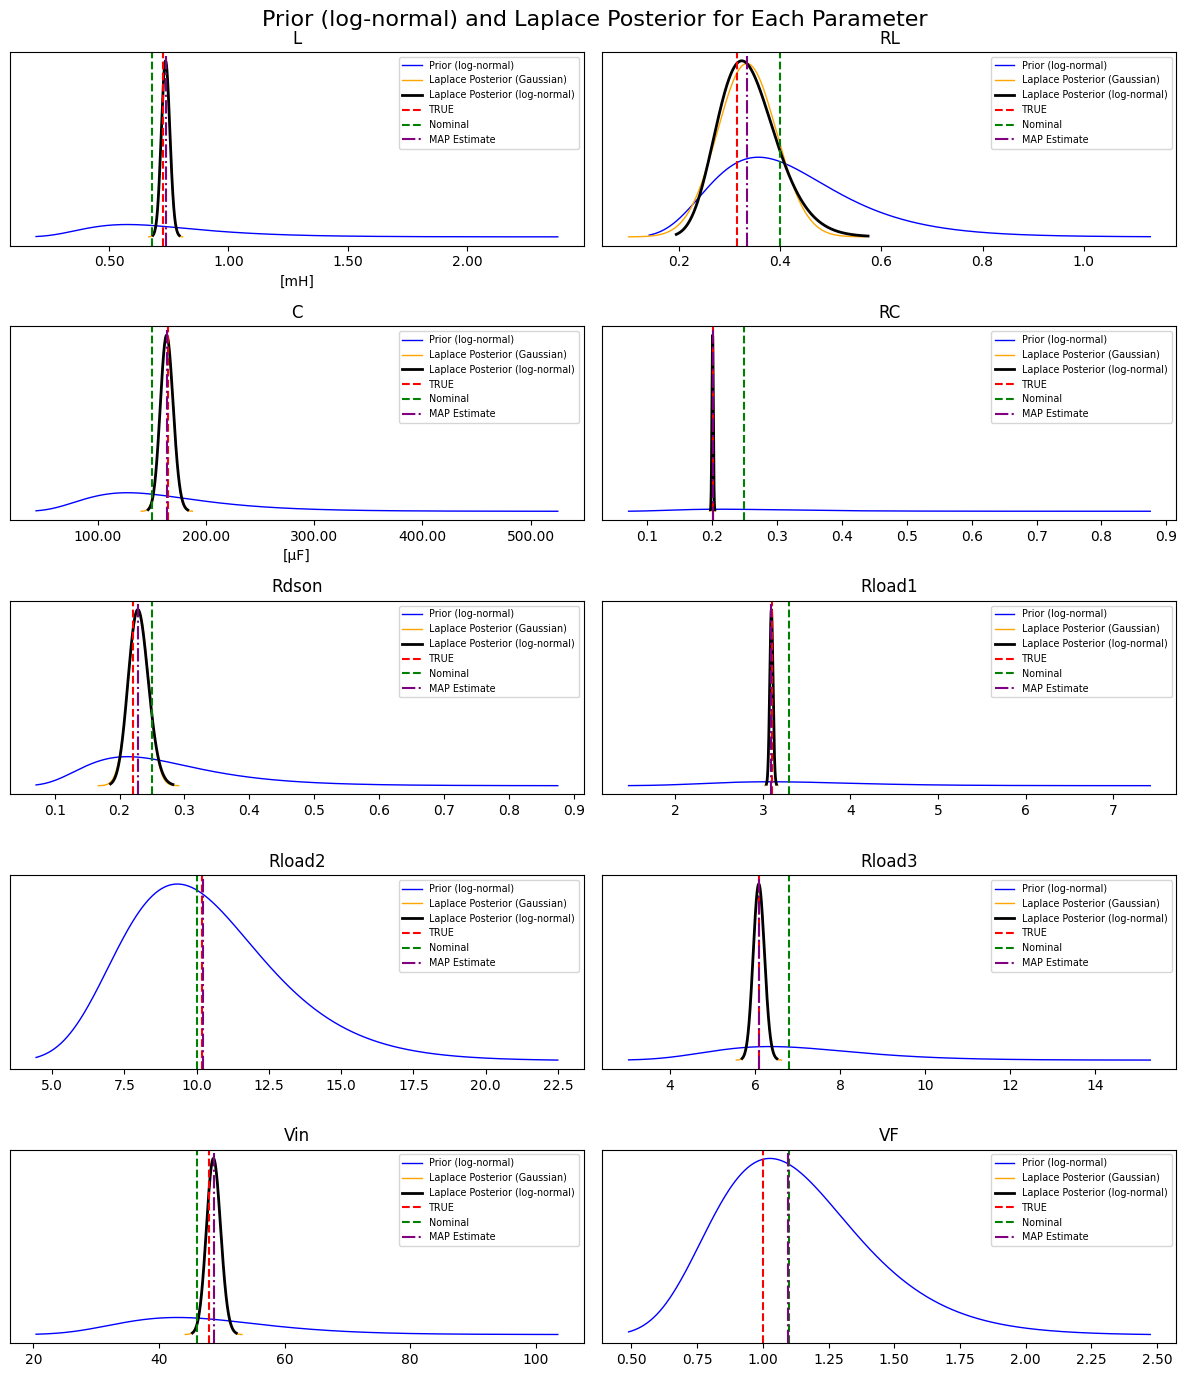

In [39]:
label = "ADC_error"  # change this to "ideal", "5 noise", or "10 noise" as needed

lfit = lfits[label]
plot_laplace_posteriors(
    lfit = lfit,
    NOMINAL=NOMINAL,
    REL_TOL=REL_TOL,
    TRUE_PARAMS=TRUE_PARAMS,
    _SCALE=_SCALE,
    runs_ordered=runs_ordered,
)

In [ ]:
def plot_single_laplace_posterior(
    param_name: str,
    lfit: LaplacePosterior,
    _SCALE: dict,
    ax: plt.Axes,
    label: str,
    style: str = "log-normal",  # or "gaussian"
    color: str = None,
    plot_prior: bool = False,
    NOMINAL: Parameters = None,
    REL_TOL: Parameters = None,
    TRUE_PARAMS: Parameters = None,
    show_map_marker: bool = True,
    marker_kwargs: dict = None,
):
    """
    Plot a single Laplace posterior distribution and optionally the prior,
    with a square marker at the MAP estimate placed on the PDF curve.

    Args:
        param_name: name of the parameter
        theta_phys: MAP in physical units
        Sigma_phys: covariance in physical units
        theta_log: MAP in log space
        Sigma_log: covariance in log space
        _SCALE: scaling dictionary
        ax: matplotlib axis to draw on
        label: label for the posterior
        style: 'log-normal' or 'gaussian'
        color: curve and marker color
        plot_prior: show log-normal prior
        NOMINAL, REL_TOL: required if plot_prior is True
        show_map_marker: draw square on posterior at MAP
        marker_kwargs: customization for square marker
    """
    param_names = Parameters._fields
    idx = param_names.index(param_name)

    mu_post = lfit.theta_phys[idx].item()
    std_post = float(torch.sqrt(lfit.Sigma_phys[idx, idx]))

    if plot_prior:
        if NOMINAL is None or REL_TOL is None:
            raise ValueError("NOMINAL and REL_TOL must be provided to plot the prior.")
        nominal = getattr(NOMINAL, param_name)
        rel_tol = getattr(REL_TOL, param_name)
        sigma_prior = np.log(1 + rel_tol)
        mu_prior = np.log(nominal)
        prior_dist = lognorm(s=sigma_prior, scale=np.exp(mu_prior))
        x_prior = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999), 500)
        y_prior = prior_dist.pdf(x_prior)
        ax.plot(x_prior, y_prior, label="Prior (log-normal)", color="black", linewidth=2)
        if show_map_marker:
            y_nominal_prior = prior_dist.pdf(nominal)
            default_marker_kwargs = {"marker": "s", "color": "black", "s": 30, "zorder": 5}
            ax.scatter([nominal], [y_nominal_prior], **default_marker_kwargs)

    if style == "gaussian":
        x = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 500)
        y = norm(loc=mu_post, scale=std_post).pdf(x)
        (line,) = ax.plot(x, y, label=label, color=color, linewidth=1)
        if show_map_marker:
            y_map = norm(loc=mu_post, scale=std_post).pdf(mu_post)
    elif style == "log-normal":
        mu_log = lfit.theta_log[idx].item() - np.log(_SCALE[param_name])
        sigma_log = float(torch.sqrt(lfit.Sigma_log[idx, idx]))
        dist = lognorm(s=sigma_log, scale=np.exp(mu_log))
        x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
        y = dist.pdf(x)
        (line,) = ax.plot(x, y, label=label, color=color, linewidth=1)
        if show_map_marker:
            y_map = dist.pdf(mu_post)
    else:
        raise ValueError(f"Unknown style '{style}'; use 'gaussian' or 'log-normal'.")

    line_color = line.get_color() if color is None else color

    # Add square marker on the curve at the MAP
    if show_map_marker:
        default_marker_kwargs = {"marker": "s", "color": line_color, "s": 30, "zorder": 5}
        if marker_kwargs:
            default_marker_kwargs.update(marker_kwargs)
        ax.scatter([mu_post], [y_map], **default_marker_kwargs)

    if TRUE_PARAMS is not None:
        true_val = getattr(TRUE_PARAMS, param_name)
        ax.axvline(true_val, color="red", linestyle="--", label="TRUE", linewidth=1)

    ax.set_title(param_name)
    ax.set_yticks([])

    if param_name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    elif param_name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

def plot_all_laplace_posteriors_grid(
    lfits: dict[str, LaplacePosterior],
    NOMINAL: Parameters,
    REL_TOL: Parameters,
    _SCALE: dict,
    TRUE_PARAMS: Parameters = None,
    skip_labels: set = {"ideal"},
    style: str = "log-normal",
):
    """
    Plot posterior PDFs from Laplace approximation for all parameters in a grid.

    Args:
        trained_models: dict[label] -> trained model
        X, y: input data tensors
        NOMINAL, REL_TOL: prior hyperparams
        _SCALE: scaling dict
        label_noise_dict: dict[label] -> data_noise_power
        TRUE_PARAMS: optional, used to show true value marker
        skip_labels: set of labels to skip (e.g. 'ideal')
        style: 'log-normal' or 'gaussian'
    """
    param_names = Parameters._fields
    ncols = 2
    nrows = int(np.ceil(len(param_names) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
    axes = axes.flatten()

    for i, param_name in enumerate(param_names):
        ax = axes[i]
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Only show prior and true param once
        show_prior = True
        true_params = TRUE_PARAMS

        for label, fit in lfits.items():
            if label in skip_labels:
                continue
            plot_single_laplace_posterior(
                param_name=param_name,
                lfit=fit,
                _SCALE=_SCALE,
                ax=ax,
                label=label,
                style=style,
                plot_prior=show_prior,
                NOMINAL=NOMINAL,
                REL_TOL=REL_TOL,
                show_map_marker=True,
                marker_kwargs={"label": None},  # avoid duplicate legend entry
                TRUE_PARAMS=true_params,
            )
            if show_prior:
                show_prior = False  # only plot once
            true_params = None

        # Add true value line (if provided)
        if TRUE_PARAMS:
            true_val = getattr(TRUE_PARAMS, param_name)
            ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

        ax.set_title(param_name)
        ax.legend(fontsize="x-small", loc="upper right")

    fig.suptitle("Laplace Posteriors with Varying Data Noise", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

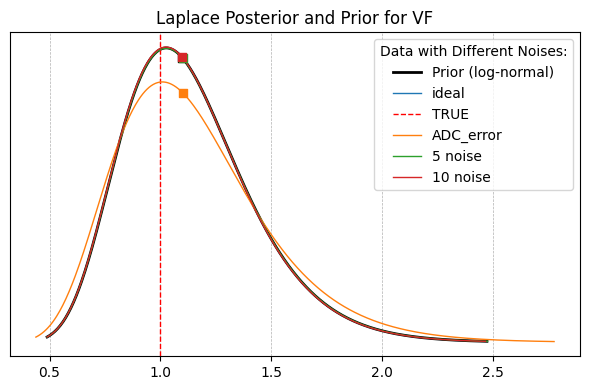

In [ ]:
parameter_name = "VF"


fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plot_prior = True
true_params = TRUE_PARAMS
for label, lfit in lfits.items():

    plot_single_laplace_posterior(
        param_name=parameter_name,
        lfit = lfit,
        _SCALE=_SCALE,
        ax=ax,
        label=label,
        style="log-normal",
        plot_prior=plot_prior,
        NOMINAL=NOMINAL,
        REL_TOL=REL_TOL,
        TRUE_PARAMS=true_params,
    )

    ax.legend(title="Data with Different Noises:")
    ax.set_title("Laplace Posterior and Prior for " + parameter_name)
    plt.tight_layout()
    plot_prior = False  # only plot prior once
    true_params = None  # don't plot TRUE_PARAMS again

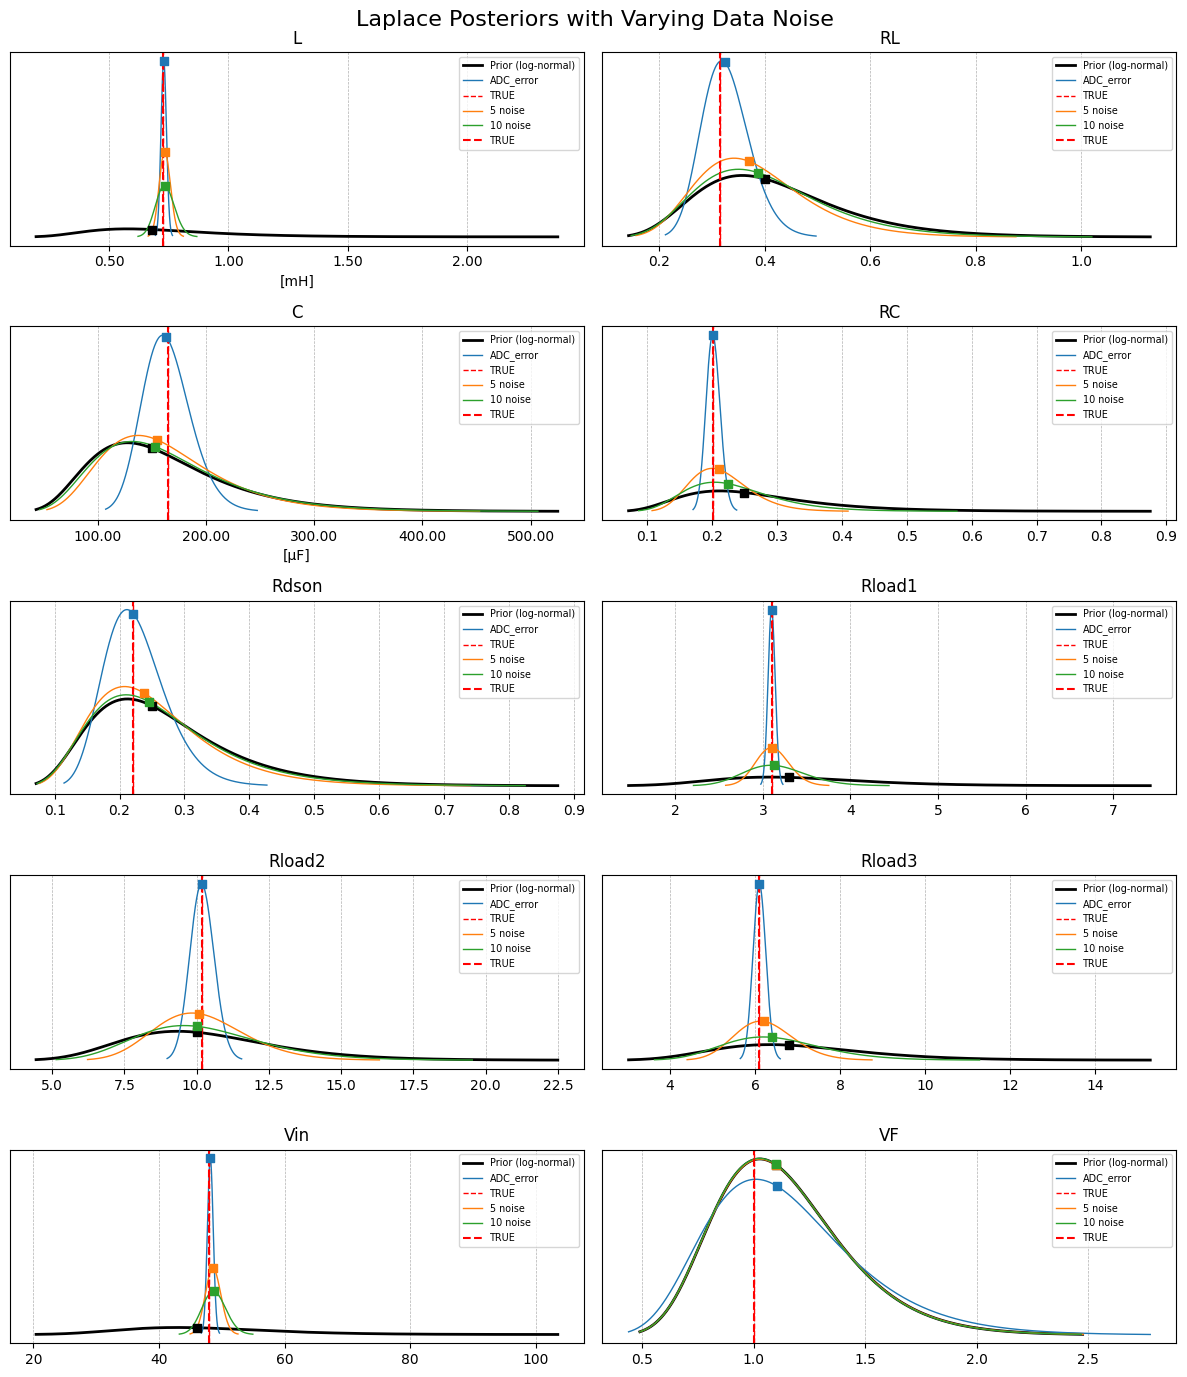

In [ ]:
plot_all_laplace_posteriors_grid(
    lfits=lfits,
    NOMINAL=NOMINAL,
    REL_TOL=REL_TOL,
    _SCALE=_SCALE,
    TRUE_PARAMS=TRUE_PARAMS,
)

Great! We have obtained posterior distributions on the estimations, which depend on the nose of the input data. 


## Limitations

#### 0. Choice of Priors 
The choice of priors is done by inspection

## Remedies and Next Steps

For points 1 and 3 we can think of different approaches to solve this problem. 

1. Rather than simply considering $x_{\text{obs}}$, estimate the true x considering this as a latent variable

2. Model the noise scale explicitly, learning $\sigma^2$ as a latent variable.

2. Use full Bayesian inference, these return better estimations of the posterior p(z | y, x): 
    + VI approach: should still be possible to use automatic-diff + Adam. 
    + HMC / NUTS: Since we only have 10 dimensions, there is no curse of dimensionality. Should be possible to draw **exact values from the posterior** without relying on surrogate models.  

---

Also, the prior effect is quite strong when the data is noisy. This may be correct and could be resolved with the previous points, but we can see what happens if we use uniform priors or **empirical Bayes**, which are chosen in a data-driven manner (maybe we can keep the nominal and only estimate $\sigma$ in this way). 